# Проект: Преобразования планов помещений в координаты опорных точек

Введение: Компания XRPlace создает интерактивные 3D квартиры и дома для сайтов застройщиков. Это похоже на web игру, где мы показываем планировку и локацию вокруг будущей недвижимости. Это особенно актуально для покупателей из других городов, а также для объектов недвижимости, которые ещё не построены. Это real time 3D в браузере, где можно гулять от первого лица, как в любой компьютерной игре (без ограничений перемещения по точкам, как у 360панорам). Для создания интерактивных 3D визуализаций необходимо по плану помещения получать координаты опорных точек и определять тип помещения для последующей 3D визуализации.

Задачи:
* Исследование открытых датасетов, релевантных для задачи
* Выбор pretrained модели и типа решаемой задачи (детекция или семантическая сегментация)
* Обучение модели на открытых датасетах
* Постпроцессинг результатов работы модели (преобразование маски или bbox в координаты углов. Результат - np.array в формате [[x y], [x y], [x y], … [x y]]
* Тестирование на данных заказчика
* Разработка gradio приложения для демонстрации

Метрика: IoU для сегментации, mAP для детекции

Стек:
* PyTorch - для работы с Deep Learning моделями
* YOLO
* Numpy для математических операций
* matplotlib и seaborn - для визуализации данных.
* Pillow, Open-CV для работы с изображениями
* Gradio для создания демо-приложения

In [54]:
#pip install ultralytics

In [55]:
#pip install gradio

In [3]:
import cv2
import numpy as np
import os

from ultralytics import YOLO
import yaml
import shutil

import random
import cv2
import matplotlib.pyplot as plt

import gradio as gr

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
# робота с Google Диском
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/My Drive/Colab Notebooks/Projects/place

/content/drive/My Drive/Colab Notebooks/Projects/place


In [11]:
!ls

best.pt  dataset  dataset2  dataset3  place.ipynb  runs  yolo11n.pt  yolov8n.pt


## Исследование датасетов

### Датасет из простых однотипных планов квартир

Описание датасета:
Возьмем уже размеченый датасет с сайта roboflow: https://universe.roboflow.com/floor-plan-recognition-research/floor-plan-wnhb5/dataset/4

Количество планов квартир: 102 шт

Размечено 2 класса комнаты и двери

Планы квартир очень простые и однотипные

In [ ]:
# Пути к датасету
images_dir = os.getcwd() + '/dataset/train/images'
print("images_dir:", images_dir)

images_dir: /content/drive/My Drive/Colab Notebooks/Projects/place/dataset/train/images


In [ ]:
# Получаем список всех изображений
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random_images = random.sample(image_files, 8)  # Выбираем 8 случайных изображений

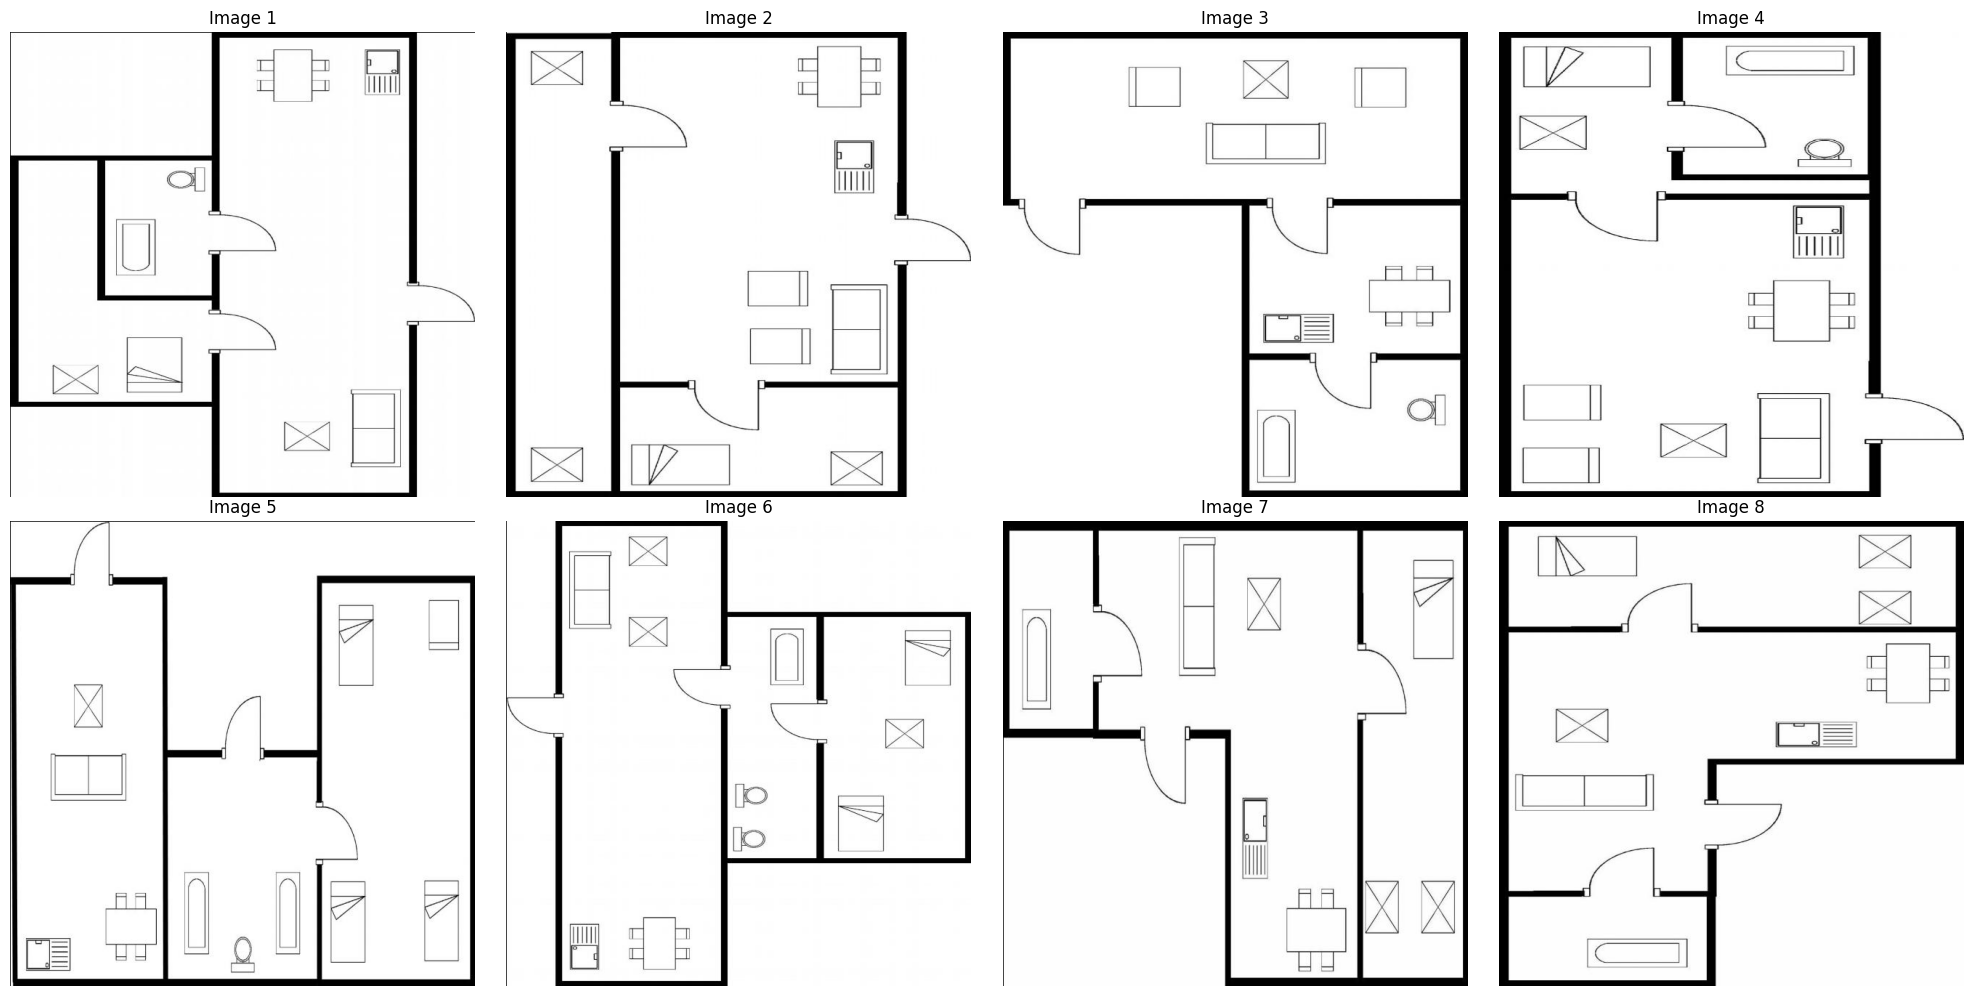

In [ ]:
plt.figure(figsize=(20, 10))
for i, img_file in enumerate(random_images):
    image_path = os.path.join(images_dir, img_file)
    image = cv2.imread(image_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image {i + 1}')

plt.tight_layout()
plt.show()

### Датасет из сложных планов квартир

Описание датасета: Возьмем датасет с сайта roboflow и разметим его вручную

Количество планов квартир: 100 шт и потом еще 100 шт

Размечено 1 класс комнаты

Планы квартир очень сложные и разнотипные

In [ ]:
# Пути к датасету
images_dir = os.getcwd() + '/dataset2/train/images'
print("images_dir:", images_dir)

images_dir: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/train/images


In [ ]:
# Получаем список всех изображений
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
random_images = random.sample(image_files, 8)  # Выбираем 8 случайных изображений

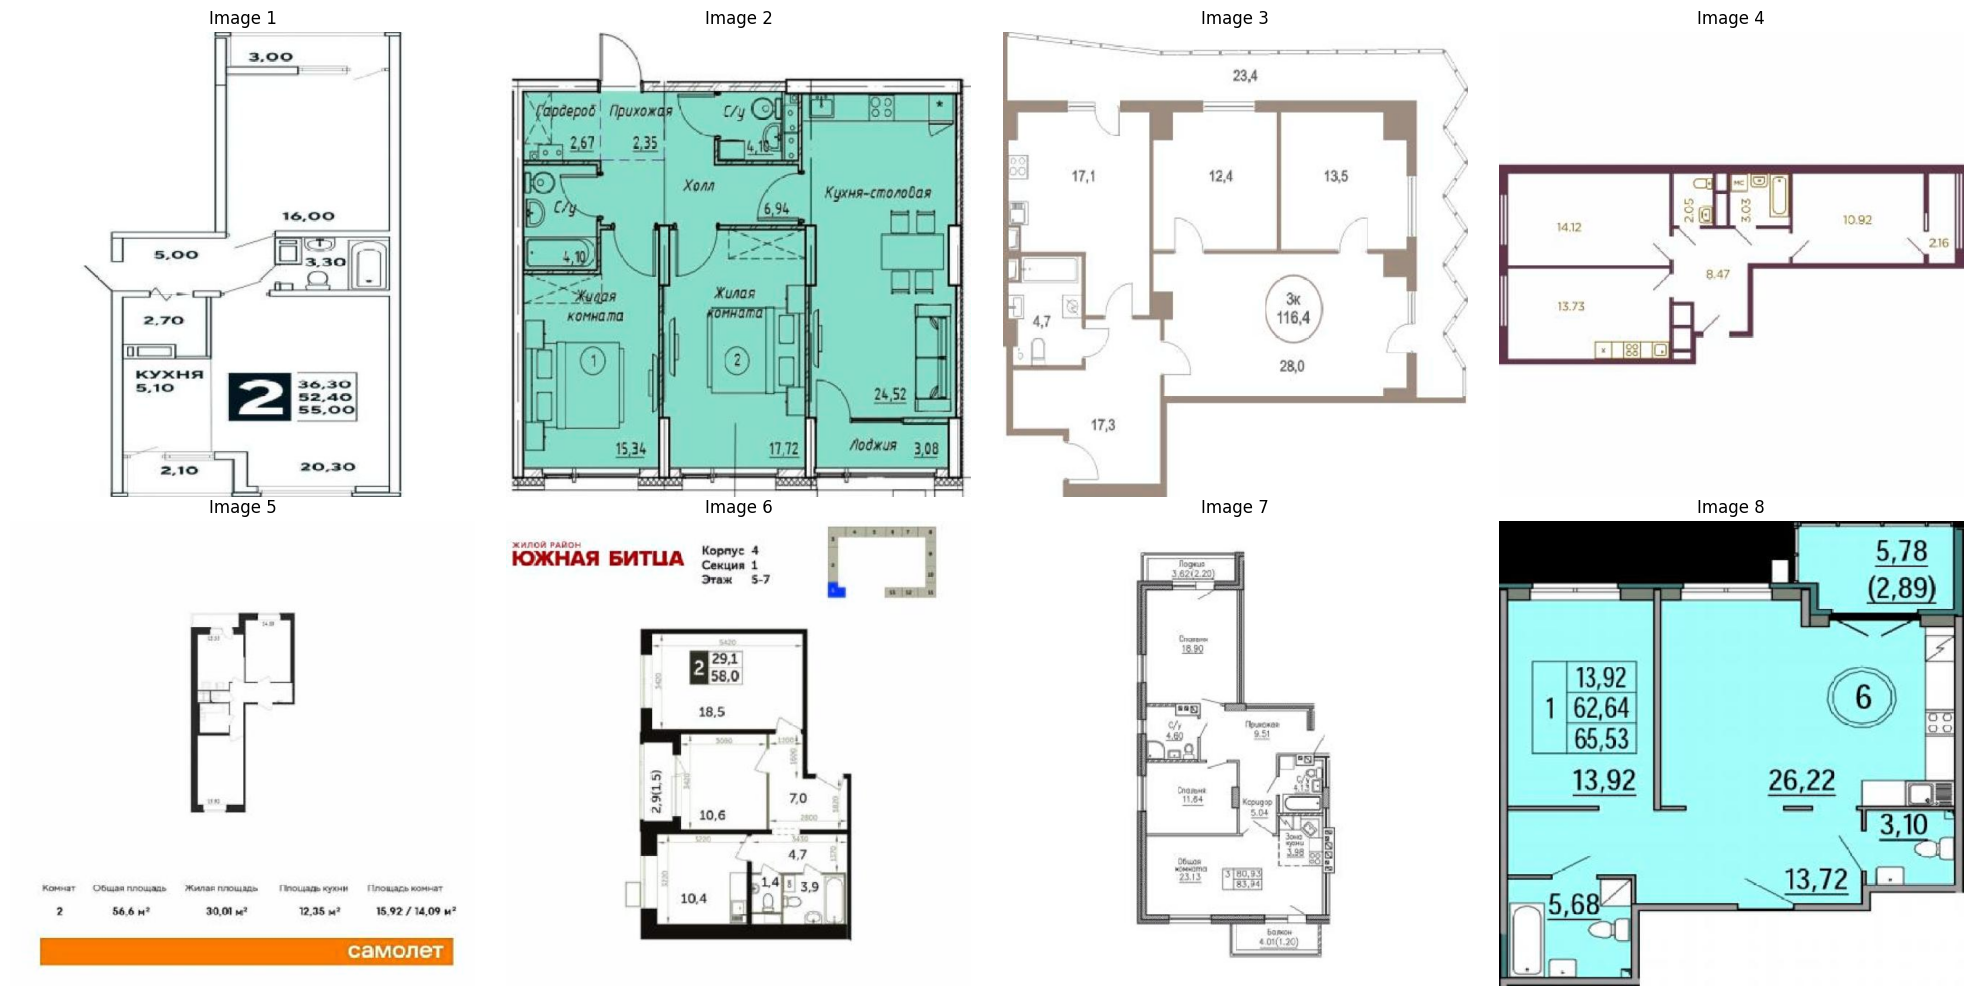

In [ ]:
plt.figure(figsize=(20, 10))
for i, img_file in enumerate(random_images):
    image_path = os.path.join(images_dir, img_file)
    image = cv2.imread(image_path)
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Image {i + 1}')

plt.tight_layout()
plt.show()

## Обучение

### Обучение на простом датасете

Дообучимся на модели yolov8n.pt используя простой датасет

In [ ]:
current_dir = os.getcwd() + '/dataset'
print("Current directory:", current_dir)

Current directory: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset


In [ ]:
data_path = os.path.join(current_dir, 'data.yaml')
model = YOLO(os.path.join(current_dir, 'yolov8n.pt'))

100%|██████████| 6.25M/6.25M [00:00<00:00, 191MB/s]


In [ ]:
epochs = 500
batch = 32
imgsz = 640

In [ ]:
if __name__ == '__main__':
    results = model.train(data=data_path,
                      epochs=epochs,
                      batch=batch,
                      imgsz=imgsz,
                      name='red',
                      device='cuda')

Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/data.yaml, epochs=500, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=red, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 103MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/train/labels... 84 images, 0 backgrounds, 0 corrupt: 100%|██████████| 84/84 [02:20<00:00,  1.67s/it]

train: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 60, len(boxes) = 475. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/valid/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]

val: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 5, len(boxes) = 58. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/red/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/red
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      3.79G       1.46      3.223      1.517        174        640: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]

                   all         10         58    0.00937      0.498     0.0664     0.0312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      3.91G      1.502      3.268      1.563        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         10         58    0.00922      0.479     0.0624     0.0278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      3.77G      1.376      3.173      1.473        165        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         10         58    0.00924      0.527      0.142     0.0916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      3.78G      1.119      2.996      1.303        172        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         10         58     0.0187      0.949      0.357       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      3.78G     0.9148      2.448       1.18        220        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         10         58      0.019      0.949      0.361      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      3.79G     0.8174      1.705      1.131        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


                   all         10         58     0.0369      0.792      0.633      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      3.79G     0.7916      1.348      1.104        156        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         10         58      0.902     0.0763      0.502      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      3.86G     0.8227       1.35       1.13        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         10         58       0.93      0.222      0.736      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      3.82G     0.8117      1.289      1.108        227        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         10         58       0.87      0.259      0.716      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      3.78G     0.7637      1.168      1.075        163        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         10         58      0.784      0.426       0.76      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      3.79G     0.7982      1.141      1.086        256        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         10         58      0.795      0.407       0.74      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      3.75G     0.7634      1.057      1.074        190        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         10         58      0.911      0.407      0.718      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      3.78G     0.7836      1.125       1.09        190        640: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         10         58      0.882      0.389      0.664      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      3.78G     0.7401       1.02      1.051        165        640: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         10         58      0.869      0.407      0.603      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      3.77G       0.68     0.9452       1.02        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


                   all         10         58      0.857      0.278      0.491      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      3.78G     0.7252      1.002      1.069        167        640: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         10         58      0.826      0.185      0.229       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      3.78G     0.7245     0.9503      1.044        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         10         58     0.0177      0.808      0.181      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      3.79G     0.7119     0.9608      1.048        197        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         10         58          1      0.052      0.311      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      3.75G     0.7269     0.9873      1.074        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         10         58      0.908      0.111      0.419       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      3.81G     0.7337      1.007      1.069        160        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         10         58      0.783      0.194      0.419      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      3.76G     0.6473      0.856      1.008        199        640: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all         10         58      0.762      0.185      0.534      0.394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      3.83G     0.6421     0.8657      1.019        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         10         58      0.832       0.22      0.559      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      3.89G     0.6749     0.8969      1.026        198        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         10         58      0.727      0.246      0.519      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      3.89G     0.6688     0.9321      1.045        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


                   all         10         58      0.634      0.319      0.467        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      3.79G     0.6793     0.8926      1.033        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         10         58      0.661      0.346      0.508      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500       3.8G     0.6842     0.9214      1.021        165        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

                   all         10         58      0.656      0.417      0.502      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      3.75G     0.6667     0.8906      1.028        224        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         10         58      0.657      0.428       0.51      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      3.81G     0.6856     0.9068      1.036        167        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         10         58      0.612      0.458      0.555      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      3.78G     0.6875     0.8572      0.998        192        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10         58      0.652      0.481      0.557      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      3.85G     0.7043     0.9557      1.073        193        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


                   all         10         58      0.627      0.475      0.621      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      3.78G     0.7246     0.9207      1.087        167        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         10         58      0.688      0.556      0.667      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500       3.8G     0.7054     0.8587      1.022        212        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         10         58      0.656      0.656      0.699      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500       3.8G      0.685     0.7974      1.018        208        640: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         10         58      0.661      0.643      0.714      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      3.85G        0.7     0.9042      1.055        182        640: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         10         58      0.763      0.719      0.738      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      3.92G      0.679      0.866      1.029        163        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         10         58      0.717      0.688      0.728      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      3.77G      0.693     0.8687      1.055        168        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         10         58      0.753      0.575      0.671      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500       3.8G     0.7028     0.8711      1.053        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         10         58      0.781      0.432      0.527      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      3.85G     0.6806     0.8837      1.033        184        640: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         10         58      0.606      0.259      0.332      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      3.76G     0.6893     0.8674      1.045        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         10         58       0.48      0.293      0.224       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500       3.8G     0.7118     0.8327      1.038        215        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         10         58      0.391      0.268      0.112     0.0781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      3.84G     0.6929     0.8115      1.029        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


                   all         10         58      0.215      0.159     0.0458     0.0408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      3.76G     0.6467     0.7247     0.9565        229        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         10         58      0.338      0.231      0.113     0.0923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500       3.8G     0.6993     0.8285      1.034        235        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         10         58      0.373      0.229      0.115     0.0919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      3.79G     0.6659     0.8195      1.022        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         10         58      0.485      0.265      0.309      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      3.79G     0.6839     0.7539     0.9807        233        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all         10         58      0.521      0.327      0.366      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      4.05G     0.6911     0.8154      1.043        171        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         10         58      0.558      0.361       0.39      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      3.86G     0.6127     0.7233     0.9745        206        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         10         58      0.573      0.412      0.451       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      3.78G     0.6421     0.7643       1.02        172        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         10         58       0.67      0.506      0.528      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      3.77G     0.6573      0.796      1.038        213        640: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         10         58       0.62      0.665      0.605      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      3.78G     0.6614     0.7745      1.019        216        640: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


                   all         10         58      0.703      0.614       0.69      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      3.77G       0.69     0.8274       1.04        194        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all         10         58      0.708      0.584      0.682      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500       3.9G     0.6759     0.7419      1.006        199        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         10         58      0.759      0.727      0.751      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      3.79G     0.6841     0.7791      1.028        208        640: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


                   all         10         58      0.807      0.829      0.797      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      3.86G      0.655     0.7587     0.9976        181        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]

                   all         10         58      0.794      0.832      0.794      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      3.78G     0.6089     0.6679     0.9658        195        640: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


                   all         10         58      0.823      0.809      0.841      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500       3.8G     0.6329     0.7723       1.04        137        640: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


                   all         10         58      0.724       0.74      0.763      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      3.77G     0.6259     0.7039     0.9867        182        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         10         58      0.632      0.713      0.636      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      3.78G     0.6009     0.7008     0.9877        195        640: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


                   all         10         58      0.701       0.75      0.718       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      3.83G     0.5924     0.6578     0.9884        153        640: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


                   all         10         58      0.739      0.859      0.793      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      3.81G     0.6344      0.747      1.021        216        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         10         58      0.811      0.808      0.834      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      3.75G     0.5605     0.6601     0.9883        151        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.12it/s]

                   all         10         58      0.768      0.838      0.844      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500       3.9G     0.5813      0.683      1.009        158        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         10         58      0.616      0.764      0.768      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      3.89G     0.5831     0.6832     0.9878        156        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         10         58      0.833      0.624      0.764      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      3.78G     0.6132     0.7049      1.015        220        640: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         10         58      0.739      0.746      0.789      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      3.75G     0.6063      0.696      1.001        159        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         10         58      0.793      0.737      0.807      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      3.79G     0.6106     0.7257     0.9785        220        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         10         58      0.758      0.712      0.789      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      3.79G     0.6087     0.6498     0.9898        201        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         10         58      0.747      0.786      0.798      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      3.77G     0.6454     0.7453      1.035        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         10         58      0.939      0.719      0.839      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      3.78G     0.6588     0.7114      1.004        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         10         58      0.771      0.912      0.847      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      3.77G     0.5868     0.6729     0.9754        264        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         10         58      0.777      0.838      0.826      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      3.78G     0.5895     0.6487     0.9701        152        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         10         58       0.82      0.764      0.837      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      3.78G     0.5819     0.6476     0.9736        166        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


                   all         10         58      0.894      0.871      0.908      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      3.84G     0.6243     0.6717     0.9889        189        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         10         58      0.882      0.907      0.911      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      3.84G     0.6252     0.6923          1        201        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         10         58      0.871      0.894      0.881      0.752

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      3.77G     0.6109     0.6773     0.9964        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         10         58      0.902      0.853      0.866      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      3.77G     0.5957     0.6588      1.018        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         10         58      0.882      0.859      0.873      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      3.77G     0.5754     0.6244     0.9839        178        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         10         58      0.896      0.887      0.891      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500       3.8G     0.6106     0.6907     0.9904        206        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10         58      0.868      0.875      0.871      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      3.79G     0.5759     0.6306     0.9734        182        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         10         58      0.919      0.836      0.868      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      3.81G     0.5701      0.637     0.9801        182        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


                   all         10         58      0.905      0.894      0.889      0.732

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      3.79G     0.6268     0.6551     0.9923        200        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         10         58      0.904       0.88      0.882      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      3.82G     0.6082      0.624      0.972        178        640: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         10         58       0.85      0.858      0.859      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      3.89G     0.6112     0.6179     0.9709        210        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         10         58      0.915      0.769       0.85      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      3.81G     0.5705     0.6085      0.962        216        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         10         58       0.86      0.773      0.835       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      3.82G     0.6069     0.6406     0.9959        197        640: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         10         58      0.805      0.852      0.832      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      3.76G     0.5836     0.6112     0.9798        167        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         10         58      0.861      0.817      0.845      0.727

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      3.76G     0.5567     0.5944      0.971        159        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         10         58       0.86      0.841      0.867      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      3.79G     0.5858     0.6178     0.9586        202        640: 100%|██████████| 3/3 [00:00<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         10         58      0.831      0.859      0.869      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      3.79G     0.5914     0.5874     0.9598        181        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         10         58      0.861      0.817      0.832      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500      3.79G     0.5693     0.6091     0.9828        169        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         10         58      0.883      0.824      0.825      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      3.76G     0.5629     0.5945     0.9847        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         10         58      0.901      0.808      0.839      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500       3.8G     0.5549     0.5845     0.9721        144        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         10         58       0.81      0.824      0.839      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      3.81G     0.5561     0.5917     0.9561        194        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         10         58      0.856      0.787      0.835      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      3.86G     0.5598     0.5775     0.9508        212        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         10         58      0.842      0.729      0.833       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      3.77G     0.5622     0.5893     0.9808        191        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         10         58      0.812      0.783      0.841      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      3.79G     0.5543     0.5815     0.9585        172        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         10         58      0.797      0.834      0.852      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500       3.8G     0.5451     0.6025     0.9778        144        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


                   all         10         58      0.881      0.745      0.844      0.725

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      3.85G     0.5624     0.6043     0.9662        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         10         58       0.89      0.769      0.837      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      3.79G     0.5558      0.595     0.9597        198        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         10         58      0.775      0.792      0.824      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500       3.8G     0.5837     0.6445      1.006        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         10         58      0.905      0.711      0.843       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500       3.9G     0.5739     0.5686     0.9685        214        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         10         58      0.919      0.712       0.84      0.722

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      3.82G     0.5639     0.5837     0.9646        201        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         10         58      0.916      0.682      0.791      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      3.88G     0.5368     0.5541     0.9464        218        640: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         10         58      0.884      0.674      0.759      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      3.79G     0.5036     0.5237     0.9383        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         10         58      0.857      0.656      0.745      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500       3.8G     0.5312     0.6062     0.9855        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


                   all         10         58      0.788      0.671       0.74      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      3.84G     0.5298     0.5484     0.9539        177        640: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         10         58      0.747      0.744      0.771       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      3.79G     0.5601     0.5587     0.9633        206        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         10         58      0.805      0.728      0.786      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      3.95G     0.5092     0.5228     0.9227        207        640: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


                   all         10         58      0.906      0.669      0.774      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      3.79G     0.5216      0.517     0.9428        181        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         10         58      0.766      0.758      0.753      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500       3.9G      0.551     0.5613     0.9719        228        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]

                   all         10         58      0.808      0.698      0.769      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      3.77G     0.5788     0.5911      1.002        239        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         10         58      0.678      0.797      0.787       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      3.78G     0.5376     0.5753     0.9645        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         10         58      0.878      0.742      0.841      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      3.78G     0.5317     0.5311     0.9454        214        640: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         10         58       0.89      0.725      0.822      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      3.79G     0.5606       0.57     0.9784        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


                   all         10         58      0.771      0.726      0.793      0.673

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      3.75G     0.5556     0.5573     0.9762        206        640: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         10         58      0.759      0.742      0.784      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      3.84G     0.5324     0.5622     0.9411        165        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         10         58      0.874      0.743      0.807      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      3.79G     0.5814     0.5708     0.9796        181        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         10         58      0.905      0.725      0.793      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      3.77G     0.5355      0.547     0.9426        241        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

                   all         10         58      0.829      0.733      0.755      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      3.76G     0.5492     0.5623      0.956        220        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         10         58      0.782       0.79      0.747      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      3.79G     0.5356     0.5784     0.9594        173        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]

                   all         10         58      0.796      0.737      0.773      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      3.76G     0.5254     0.5458      0.939        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         10         58      0.877      0.701      0.779      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500       3.8G     0.5269     0.5202      0.938        219        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         10         58      0.855      0.753      0.818      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      3.79G     0.5172     0.5114     0.9532        204        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         10         58      0.818      0.804      0.831      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      3.84G     0.5471     0.5559     0.9659        148        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         10         58      0.798      0.841      0.819      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      3.78G     0.5227     0.5524     0.9481        202        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         10         58      0.879      0.731      0.806      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      3.84G     0.5038     0.5159     0.9479        190        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         10         58      0.868      0.729      0.774      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      3.75G     0.5357     0.5559     0.9602        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         10         58      0.834      0.718      0.773      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500       3.8G     0.5403     0.5572     0.9488        239        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         10         58      0.748      0.718       0.74      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500       3.8G     0.5316     0.5174     0.9351        214        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         10         58      0.696       0.68      0.719      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      3.78G     0.5286     0.5294     0.9531        189        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         10         58      0.732      0.633      0.687      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500       3.8G     0.4863     0.4898      0.931        195        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         10         58      0.798      0.562      0.688      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      3.79G      0.475     0.4562     0.9052        201        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


                   all         10         58      0.839      0.626       0.77      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500       3.8G     0.5448     0.5924      0.962        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all         10         58      0.654      0.735      0.728      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      3.84G     0.5047     0.5388     0.9438        186        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         10         58      0.721      0.715      0.737      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      3.79G     0.5527     0.5633     0.9623        213        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         10         58       0.77      0.646      0.729      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      3.79G      0.475     0.4834     0.9128        189        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]


                   all         10         58      0.777      0.676      0.721      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      3.83G     0.4908     0.5015     0.9239        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         10         58      0.854      0.692      0.749      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      3.78G      0.483     0.4866     0.9271        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         10         58      0.783      0.803      0.825      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      3.79G     0.5191     0.5212     0.9574        203        640: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         10         58      0.852      0.848      0.836      0.718

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      3.78G     0.4836     0.4674     0.9313        161        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


                   all         10         58      0.865      0.859      0.835      0.741

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500       3.8G     0.5487     0.5488     0.9759        194        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         10         58      0.868      0.859      0.832      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      3.82G     0.5217     0.5114     0.9601        191        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         10         58      0.897      0.859      0.833      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      3.83G     0.5314     0.5558     0.9557        166        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         10         58      0.864      0.854      0.837      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      3.96G     0.5136     0.4916      0.932        209        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


                   all         10         58      0.866      0.821      0.841      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      3.89G     0.5258     0.5379     0.9498        161        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]


                   all         10         58       0.88      0.859      0.848      0.708

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500       3.8G     0.5164     0.4922     0.9366        207        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         10         58      0.914      0.878      0.863       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      3.79G     0.5046     0.4708     0.9363        227        640: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         10         58      0.896      0.878      0.858      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      3.78G     0.4631     0.4644     0.9054        178        640: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         10         58      0.886      0.876      0.863      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      3.97G     0.5114     0.5401      0.961        190        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         10         58      0.902      0.867      0.866      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      3.84G     0.4653     0.4489     0.9266        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         10         58      0.849      0.859      0.858      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      3.84G      0.536     0.5163     0.9596        207        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


                   all         10         58      0.844      0.872       0.86      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      3.81G     0.4736     0.4544     0.9206        179        640: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


                   all         10         58      0.882      0.826      0.865      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      3.84G     0.4973     0.4795     0.9301        190        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         10         58      0.861      0.857      0.863      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      3.79G     0.5177     0.5017     0.9282        189        640: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         10         58      0.919      0.832      0.863      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      3.84G     0.5106     0.4967     0.9307        193        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         10         58      0.914      0.838       0.86      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500         4G      0.534     0.5281     0.9561        195        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


                   all         10         58      0.897      0.856      0.865      0.767

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      3.87G     0.5038     0.4927     0.9467        193        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         10         58      0.898      0.873      0.872      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500       3.8G     0.4934     0.4966      0.938        180        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]

                   all         10         58      0.882      0.885       0.88      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      3.77G     0.4967      0.487     0.9432        164        640: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         10         58      0.879      0.894      0.889      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      3.79G     0.5054     0.4791     0.9344        210        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         10         58       0.92       0.87      0.898      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      3.79G     0.4781      0.449     0.9068        211        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         10         58       0.92      0.874      0.902      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500       3.8G     0.4684     0.4674     0.9333        198        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         10         58      0.852      0.891      0.888      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      3.78G     0.4969     0.4867     0.9428        174        640: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]


                   all         10         58      0.835      0.886       0.88      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      3.77G     0.4888      0.464     0.9246        209        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.15it/s]

                   all         10         58       0.89      0.893      0.885      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500      3.75G     0.4885     0.4562     0.9294        161        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]

                   all         10         58      0.892      0.894      0.887      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      3.76G     0.4995     0.5238     0.9511        173        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]

                   all         10         58      0.875      0.882       0.88       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      3.93G     0.5016     0.4776     0.9334        196        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         10         58      0.841      0.899      0.869      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      3.93G     0.4941     0.4439     0.9189        198        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         10         58      0.841      0.896      0.866      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      3.75G     0.4767     0.4394     0.9114        161        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


                   all         10         58       0.82      0.909      0.866      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      3.79G     0.4976     0.4907     0.9542        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         10         58       0.89      0.847      0.852      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      3.76G     0.4891     0.4646     0.9085        226        640: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         10         58      0.879      0.831      0.838      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      3.76G     0.4658     0.4551     0.9287        174        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         10         58      0.882      0.841      0.834       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      3.78G     0.4851     0.4665     0.9369        170        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.69it/s]

                   all         10         58      0.883      0.859      0.835      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500       3.8G      0.451     0.4377     0.9156        184        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]


                   all         10         58      0.874      0.859      0.844       0.74

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      3.75G     0.4967     0.4732     0.9413        194        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]

                   all         10         58      0.886      0.859      0.855      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      3.76G     0.4907     0.4726     0.9424        209        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         10         58      0.895      0.865      0.853      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      3.84G     0.4907     0.5066     0.9486        238        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

                   all         10         58      0.896      0.838       0.86       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      3.91G     0.4867     0.4805     0.9373        179        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         10         58      0.876      0.826      0.857      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      3.85G     0.4936     0.4531     0.9245        241        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         10         58      0.863      0.837      0.863       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      3.79G     0.4621     0.4494     0.9068        170        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         10         58      0.882      0.838      0.863      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      3.72G     0.4925     0.4752     0.9557        163        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


                   all         10         58       0.88      0.838      0.865      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      3.77G     0.4571      0.438     0.9152        233        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         10         58      0.894      0.854      0.862      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      3.86G     0.4548     0.4627      0.922        217        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all         10         58      0.924      0.852      0.865      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      3.81G     0.4743     0.4643     0.9284        200        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         10         58       0.84      0.909      0.862      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      3.79G     0.4308     0.4094     0.8966        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.29it/s]

                   all         10         58      0.849      0.896      0.863      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      3.77G     0.4834     0.4627     0.9309        196        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         10         58      0.865      0.895      0.875      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      3.78G     0.4709     0.4739     0.9193        187        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         10         58      0.865      0.876       0.87      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      3.81G     0.4895     0.4878     0.9375        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all         10         58      0.881      0.859       0.85      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      3.91G     0.4761     0.4499     0.9239        225        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


                   all         10         58      0.902      0.836      0.839      0.743

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      3.76G     0.4462     0.4193     0.9052        183        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


                   all         10         58      0.877      0.843      0.835      0.721

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      3.79G     0.4886     0.4798     0.9457        156        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         10         58      0.886      0.854      0.846      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500       3.8G     0.4865     0.4529     0.9332        205        640: 100%|██████████| 3/3 [00:00<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         10         58        0.9      0.854      0.848      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      3.82G     0.4574     0.4362     0.9092        215        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         10         58      0.903      0.875      0.849      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500      3.81G      0.477     0.4398     0.9123        228        640: 100%|██████████| 3/3 [00:00<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         10         58      0.919      0.838      0.852      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500      3.76G     0.4859     0.4581     0.9151        189        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         10         58      0.865      0.875      0.856      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500       3.9G     0.4564     0.4069     0.8988        227        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         10         58      0.881      0.875      0.865       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500      3.78G     0.4638     0.4449     0.9402        206        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


                   all         10         58      0.882      0.875      0.881      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      3.77G     0.4347     0.3954     0.8976        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         10         58      0.901      0.874      0.887       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      3.78G     0.4501     0.4269     0.9164        205        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         10         58      0.871      0.892      0.887       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500       3.8G     0.4343      0.404     0.9003        196        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         10         58      0.905      0.874      0.884      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      3.79G     0.4283     0.4099     0.9085        171        640: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]


                   all         10         58      0.904      0.875      0.879      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      3.84G     0.4677     0.4212     0.9228        186        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         10         58      0.906      0.875      0.869      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500       3.9G     0.4573     0.4514      0.918        163        640: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         10         58      0.892      0.878      0.872      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500      3.92G     0.4631     0.4364     0.9213        200        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         10         58      0.877      0.884       0.87      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      3.77G     0.4549     0.4372      0.919        191        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         10         58      0.873      0.894      0.873      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      3.79G     0.4273     0.4126     0.9031        207        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         10         58      0.876      0.876      0.864      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      3.92G     0.4547     0.4291     0.9381        178        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         10         58      0.873      0.877      0.857      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      3.76G     0.4491     0.4242      0.918        221        640: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         10         58      0.873      0.878      0.851      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      3.91G     0.4793     0.4412     0.9366        193        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         10         58      0.875      0.878      0.846      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      3.79G     0.4319     0.4205     0.9159        175        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         10         58      0.875      0.859      0.853      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500      3.83G       0.46     0.4143     0.9136        172        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         10         58      0.873      0.859      0.852      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      3.85G     0.4323     0.4026     0.8991        226        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         10         58      0.886      0.844      0.868      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      3.79G     0.4706     0.4293     0.9271        215        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         10         58      0.858      0.862      0.864      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500       3.8G     0.4379     0.4205     0.9151        199        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         10         58      0.855      0.857      0.877      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500      3.76G     0.4196     0.3968     0.8815        204        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all         10         58       0.88      0.857      0.889      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500       3.8G     0.4699     0.4461     0.9278        218        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


                   all         10         58      0.896      0.857      0.897      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      3.88G     0.4523     0.4149     0.9213        240        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


                   all         10         58      0.909      0.857      0.899      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      3.85G     0.4276     0.4017     0.9042        173        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         10         58      0.864      0.857      0.893      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500      3.81G     0.4677     0.4506     0.9487        225        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         10         58      0.871      0.819       0.88      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      3.79G     0.4302     0.4139     0.9035        179        640: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]

                   all         10         58      0.888      0.767      0.851      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      3.78G     0.4475     0.4153     0.9247        178        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         10         58      0.808      0.803      0.846      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500      3.83G     0.4426     0.4079     0.8985        211        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]

                   all         10         58      0.901      0.829      0.859      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500      3.77G     0.4159     0.3819     0.8944        187        640: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         10         58      0.894      0.838      0.867      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500      3.78G     0.4539     0.4252     0.9266        204        640: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]

                   all         10         58       0.92      0.832      0.857      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      3.79G     0.4469     0.4086     0.9104        192        640: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]

                   all         10         58      0.901      0.829      0.853       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      3.87G     0.4394     0.3851     0.8997        190        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         10         58      0.884      0.769      0.831      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500      3.79G     0.4422     0.4403     0.9276        196        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]

                   all         10         58       0.86      0.824      0.848      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500       3.8G     0.4119     0.4012     0.9007        188        640: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         10         58       0.84      0.859      0.867      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      3.76G     0.4231     0.4146      0.884        176        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         10         58      0.884       0.82      0.885       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500       3.9G     0.4209      0.416     0.9029        204        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         10         58      0.879      0.894      0.887      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500      3.83G     0.3997     0.3844     0.8887        156        640: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         10         58      0.898      0.915      0.884      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      3.86G      0.471     0.4543     0.9414        184        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         10         58      0.888      0.885      0.887      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      3.77G     0.4295     0.4135     0.9206        194        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         10         58      0.865      0.896      0.866      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      3.76G      0.434     0.4121       0.91        164        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         10         58      0.861      0.894      0.857      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500      3.79G      0.439     0.4031     0.8987        207        640: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]

                   all         10         58      0.844      0.896       0.85      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      3.79G     0.4572     0.4233     0.9067        210        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


                   all         10         58       0.86      0.891      0.856      0.754

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      3.78G     0.4397     0.4183     0.9095        199        640: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         10         58      0.842      0.883      0.855      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      3.79G     0.4412     0.4032     0.9013        170        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.32it/s]

                   all         10         58      0.896       0.88      0.867      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      3.77G     0.4292     0.4101     0.9249        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         10         58      0.889      0.884      0.868      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500      3.81G      0.425     0.4237     0.9068        208        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


                   all         10         58      0.923      0.859       0.87      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      3.79G     0.4327     0.4057     0.9025        184        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

                   all         10         58      0.873      0.878      0.871      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      3.79G     0.4277     0.4119     0.9077        211        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all         10         58      0.878       0.87      0.879      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      3.84G      0.431     0.4028     0.9213        173        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         10         58      0.854      0.905      0.884      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      3.89G     0.4342      0.385     0.9204        162        640: 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         10         58      0.904      0.875      0.893      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      3.79G     0.4431     0.3836     0.9105        186        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         10         58      0.899      0.892      0.888      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500      3.94G        0.4     0.3849     0.8908        193        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         10         58      0.917      0.875      0.872      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      3.79G     0.4037     0.3864     0.9052        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         10         58      0.921      0.875       0.87       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500      3.79G     0.4414     0.4291     0.9172        148        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.57it/s]

                   all         10         58      0.905      0.874      0.868      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500      3.79G     0.4445     0.4366     0.9398        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         10         58      0.905      0.872      0.876      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      3.77G      0.415     0.4001     0.9123        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all         10         58      0.895      0.873      0.867      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      3.78G     0.4403     0.4049     0.9208        155        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         10         58      0.895       0.84       0.86       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      3.79G     0.4126     0.3811     0.8939        198        640: 100%|██████████| 3/3 [00:01<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         10         58      0.898      0.841      0.855      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      3.79G      0.427     0.3939     0.9015        209        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         10         58      0.897      0.841      0.857      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      3.77G     0.4188     0.4025     0.8999        179        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         10         58       0.92      0.837       0.86      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      3.79G     0.4479     0.4207     0.9108        191        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         10         58      0.897      0.841      0.854       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500      3.79G     0.4138     0.3913     0.8959        204        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         10         58      0.891      0.859      0.855      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      3.82G     0.4249     0.3958     0.9123        195        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


                   all         10         58      0.878      0.859      0.861      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      3.79G     0.4235     0.3967     0.9099        158        640: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.20it/s]


                   all         10         58      0.866      0.856       0.86      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      3.79G     0.4211     0.3967     0.9094        172        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         10         58      0.901       0.82      0.859      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500      3.78G     0.4554     0.3919     0.9212        219        640: 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


                   all         10         58      0.887      0.819       0.86      0.753
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 160, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

260 epochs completed in 0.158 hours.
Optimizer stripped from runs/detect/red/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/red/weights/best.pt, 6.3MB

Validating runs/detect/red/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


                   all         10         58      0.921       0.87      0.898      0.807
                  door         10         31      0.925      0.935      0.938      0.766
                  room         10         27      0.916      0.805      0.857      0.849
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/red


В результате на 160 эпохе получил лучшую модель с метрикой mAP50-95 = 0.849. Это неплохой результат, учитывая простоту датасета.

Для заказчика использование этой модели возможно только на данных с однотипными планами квартир, как в этом датасете.

### Сложный датасет 100 imeges

Дообучимся на модели этот раз используя более современный вариант yolov11n.pt используя сложный датасет мною размеченный на 100 планов квартир

In [ ]:
current_dir = os.getcwd() + '/dataset2'
print("Current directory:", current_dir)

Current directory: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2


In [ ]:
data_path = os.path.join(current_dir, 'data.yaml')
model = YOLO(os.path.join(current_dir, 'yolo11n.pt'))

100%|██████████| 5.35M/5.35M [00:00<00:00, 207MB/s]


In [ ]:
epochs = 500
batch = 32
imgsz = 640

In [ ]:
if __name__ == '__main__':
    results = model.train(data=data_path,
                      epochs=epochs,
                      batch=batch,
                      imgsz=imgsz,
                      name='red',
                      device='cuda')

New https://pypi.org/project/ultralytics/8.3.78 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/yolo11n.pt, data=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/data.yaml, epochs=500, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=red2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fal

train: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [02:52<00:00,  2.00s/it]

train: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 120, len(boxes) = 263. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/valid/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:31<00:00,  1.99s/it]

val: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset2/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 27, len(boxes) = 43. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/red2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/red2
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      4.46G       1.66      2.993      1.745        102        640: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         16         43    0.00708      0.791      0.129     0.0525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      4.39G      1.679      2.948      1.758         98        640: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         16         43     0.0075      0.837     0.0993     0.0442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      4.37G       1.56       2.93      1.707         98        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         16         43    0.00729      0.814      0.326       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      4.37G      1.086      2.685      1.332        120        640: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         16         43    0.00708      0.791      0.388      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500       4.4G      1.051      2.529      1.309        150        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


                   all         16         43    0.00708      0.791      0.367      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      4.38G      1.043      2.221      1.337        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         16         43    0.00708      0.791      0.197       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500       4.4G     0.9852      2.088      1.275         96        640: 100%|██████████| 3/3 [00:01<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         16         43    0.00667      0.744      0.331      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500       4.4G       1.02       1.98      1.279        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all         16         43    0.00604      0.674      0.203      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      4.38G      1.033      1.818      1.321        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         16         43    0.00604      0.674      0.125     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      4.36G       1.02      1.763      1.299         98        640: 100%|██████████| 3/3 [00:01<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         16         43      0.186       0.14      0.122     0.0409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      4.39G     0.9328      1.571      1.242        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         16         43     0.0145      0.744      0.237       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500      4.34G     0.9359      1.588      1.246        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all         16         43      0.119      0.628      0.268       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      4.38G     0.9541      1.602      1.267        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         16         43      0.539      0.395      0.377      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      4.38G     0.8716      1.475      1.207        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         16         43      0.184     0.0465       0.13     0.0724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      4.39G     0.9956      1.554      1.295        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all         16         43      0.256     0.0481     0.0916      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      4.37G     0.9838      1.493      1.284        144        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         16         43      0.473      0.116      0.153      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      4.39G     0.9857      1.435      1.306        116        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]

                   all         16         43      0.677      0.372      0.424      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500       4.4G     0.9712      1.412      1.234        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


                   all         16         43       0.52      0.465       0.45      0.299

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500       4.4G     0.9579      1.331      1.235        151        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         16         43      0.583      0.465      0.462      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500      4.39G     0.9026      1.363      1.194        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         16         43      0.763      0.151      0.338      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      4.39G     0.9793      1.379      1.257        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         16         43      0.645     0.0435      0.219      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      4.38G       0.95      1.354      1.232        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         16         43      0.399      0.116      0.135     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      4.39G     0.9305      1.338      1.231        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         16         43      0.185      0.186     0.0908     0.0526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      4.39G     0.8617      1.219      1.165        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         16         43     0.0812      0.256     0.0615     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500      4.38G     0.9141      1.292      1.208        126        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         16         43      0.109      0.211     0.0566     0.0276

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      4.38G     0.9473      1.357      1.246        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         16         43      0.124      0.093      0.107     0.0722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      4.37G     0.9124      1.373      1.216        147        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         16         43      0.485      0.197      0.275      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500      4.38G      0.937      1.367      1.243        146        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all         16         43      0.408      0.256      0.254      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      4.38G     0.9049      1.305      1.225        107        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         16         43      0.108     0.0698     0.0858     0.0386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      4.38G     0.9083      1.298      1.212        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         16         43     0.0814      0.093     0.0453     0.0244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      4.38G     0.8835      1.267      1.197        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         16         43     0.0497      0.163     0.0342     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      4.39G     0.9181      1.331      1.222        134        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         16         43      0.105       0.14     0.0608     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500       4.4G     0.8524      1.198      1.172        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         16         43      0.216       0.18     0.0902      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500      4.38G     0.9696      1.343      1.243        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         16         43      0.298      0.163       0.14     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      4.38G     0.9411      1.284      1.236        123        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         16         43      0.263      0.093     0.0552     0.0299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      4.38G     0.9444      1.332      1.241         95        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         16         43    0.00583      0.651    0.00964    0.00313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      4.34G     0.9126      1.258      1.204        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         16         43     0.0293     0.0698     0.0135    0.00383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      4.39G     0.9914      1.351      1.256        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         16         43      0.311      0.168      0.129     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      4.34G     0.9671      1.331      1.238        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         16         43      0.108     0.0465     0.0386      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      4.39G     0.9396      1.288      1.225        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         16         43    0.00521      0.581     0.0138     0.0034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      4.37G     0.9031      1.241      1.203        153        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         16         43     0.0702     0.0698     0.0216    0.00478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      4.39G      1.028      1.365      1.303        119        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         16         43      0.152     0.0698      0.024     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      4.38G     0.9646      1.218      1.222        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         16         43     0.0569     0.0698     0.0163    0.00351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      4.38G     0.9745      1.343      1.258         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         16         43      0.108      0.116     0.0407     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      4.39G     0.8911      1.199      1.191        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         16         43      0.259      0.186      0.116     0.0633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      4.38G     0.8834      1.206      1.215        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         16         43      0.497      0.233      0.216      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      4.39G     0.8822      1.165      1.177        106        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         16         43      0.341      0.233      0.216      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500      4.37G     0.8595      1.146      1.189        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         16         43      0.313      0.209      0.151     0.0728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      4.39G     0.8323      1.105      1.147        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         16         43      0.368      0.256       0.17      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500       4.4G     0.8646      1.168      1.162        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         16         43      0.533      0.349      0.296       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      4.38G     0.8429      1.148      1.201         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         16         43      0.561      0.208      0.207      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500      4.39G     0.8517      1.115      1.182        138        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         16         43      0.144     0.0698     0.0446     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      4.39G     0.8762      1.116      1.178        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         16         43      0.103     0.0698     0.0239     0.0118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500      4.38G     0.9123      1.143      1.225        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         16         43      0.143     0.0698     0.0554     0.0382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500       4.4G     0.8966      1.188      1.214        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.219      0.163     0.0933     0.0418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      4.39G     0.8408      1.136      1.218         89        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         16         43      0.384      0.372      0.239      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      4.34G     0.8059      1.094       1.15        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         16         43      0.548      0.349      0.353      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      4.39G     0.8552      1.132       1.18        134        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         16         43      0.583      0.302      0.355      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      4.37G     0.7868     0.9942      1.137        101        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         16         43      0.548      0.339      0.387      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      4.39G     0.9288      1.185      1.261        106        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         16         43      0.529      0.558      0.436      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500       4.4G     0.8301      1.104      1.146        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         16         43      0.685      0.465      0.434      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      4.39G     0.8482      1.204      1.193         84        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         16         43      0.422      0.488      0.411      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      4.38G     0.9327      1.227      1.287        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         16         43      0.402      0.465      0.369      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      4.38G     0.8433      1.102      1.148        115        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         16         43      0.507      0.535      0.422      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      4.39G     0.8704      1.073      1.162        140        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         16         43      0.461      0.465      0.399      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      4.38G     0.9216      1.194      1.254         88        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.70it/s]

                   all         16         43       0.63      0.516      0.458      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      4.38G     0.9079      1.198      1.232        103        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         16         43      0.625      0.558      0.485        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      4.38G     0.8223      1.054       1.16        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         16         43      0.724       0.55      0.569      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      4.39G     0.9061      1.114      1.222        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         16         43      0.651      0.512      0.544      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      4.38G     0.8787      1.178      1.217        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         16         43      0.672      0.558      0.503      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500      4.34G       0.84      1.087      1.167        142        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         16         43      0.655      0.558      0.503      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500       4.4G     0.9152      1.148      1.235        134        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         16         43      0.468      0.558        0.4      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      4.38G     0.8637      1.121      1.204        125        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         16         43       0.49      0.535      0.445      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      4.39G     0.8513      1.135      1.227        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         16         43      0.471      0.642       0.48      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500       4.4G     0.7829      1.049      1.136        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         16         43      0.572      0.466      0.502      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      4.39G     0.8677      1.091      1.189        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all         16         43      0.663      0.465      0.487      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      4.34G     0.8403      1.064      1.185        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         16         43      0.572      0.512      0.423      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      4.38G     0.8578      1.098      1.217        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         16         43      0.501      0.419      0.288      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500      4.38G     0.7592      1.009      1.119        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         16         43      0.312      0.349      0.172     0.0976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      4.38G     0.7754     0.9915      1.115        113        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.404      0.465       0.28      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      4.37G     0.8021     0.9948      1.189        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         16         43      0.431      0.372      0.302      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      4.39G     0.7817     0.9911      1.142        144        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         16         43       0.35      0.233      0.153     0.0786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      4.39G     0.7736     0.9362       1.11        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         16         43      0.137      0.186     0.0625     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      4.39G     0.8591      1.085      1.193         78        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         16         43      0.289      0.372      0.231      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      4.34G     0.7468     0.8989      1.129        102        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.652      0.581       0.48       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500       4.4G      0.844       1.07      1.199        149        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         16         43       0.73      0.581      0.532      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      4.34G      0.831      1.051      1.171        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         16         43      0.702      0.493      0.456       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      4.38G     0.7623     0.9705      1.126        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         16         43      0.621      0.349      0.329      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      4.34G     0.7692     0.9823       1.14        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         16         43      0.487      0.442       0.38      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500       4.4G      0.762     0.9224      1.148         86        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         16         43      0.639      0.453      0.454      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      4.39G       0.81      1.007      1.157        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]

                   all         16         43      0.579      0.581      0.537      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      4.39G     0.7339     0.9077      1.111        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         16         43      0.497      0.391      0.349      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      4.39G     0.8255      1.043      1.184        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         16         43      0.484       0.14       0.16     0.0862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      4.39G     0.7465      0.928       1.12        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         16         43      0.335       0.14       0.12     0.0848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      4.38G     0.7871      1.019      1.192         95        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         16         43      0.762       0.14      0.155      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      4.38G     0.7997     0.9722      1.169        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         16         43      0.418      0.217      0.225      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      4.38G     0.7994     0.9836      1.171        118        640: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         16         43      0.519      0.302      0.279        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      4.39G      0.747     0.9539      1.118        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         16         43      0.616      0.485      0.446      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500      4.39G     0.7337     0.8609      1.083        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         16         43      0.544      0.512      0.487      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      4.38G     0.7524     0.9535      1.138        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         16         43      0.664      0.535      0.545      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500       4.4G     0.7104     0.8475      1.096        118        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


                   all         16         43      0.694      0.535      0.541      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      4.38G     0.7611      0.946      1.158         94        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         16         43       0.72      0.512       0.52      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      4.38G     0.7182     0.9061      1.103        129        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         16         43      0.638      0.512      0.498      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500       4.4G     0.6978     0.8848      1.079        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]

                   all         16         43      0.626      0.488      0.535      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      4.42G      0.728     0.8595      1.074        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         16         43      0.538      0.581      0.528      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      4.39G     0.7399     0.9358      1.109        150        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         16         43      0.564      0.581      0.493       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      4.38G     0.7475     0.9504      1.144        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         16         43      0.584      0.581      0.513      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      4.39G     0.7041     0.8455      1.088         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         16         43      0.606      0.605      0.548      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500       4.4G     0.7204     0.8612      1.076        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all         16         43      0.593      0.576      0.565      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500      4.38G     0.6828      0.841      1.102        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         16         43      0.597      0.651      0.556      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      4.39G     0.7813     0.8776      1.167        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         16         43      0.638      0.697      0.568      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500      4.38G     0.7888     0.9148      1.152        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         16         43      0.684      0.721      0.568      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500      4.39G     0.6894     0.8359      1.086        103        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         16         43      0.783      0.698      0.589      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      4.38G     0.7514      0.928      1.128        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         16         43      0.735      0.674      0.566      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500      4.39G     0.7305     0.8976      1.145        116        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         16         43      0.613      0.674      0.547        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500      4.38G     0.7932      0.967      1.201         92        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         16         43      0.565      0.605      0.534      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500       4.4G     0.6954     0.8081      1.086        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         16         43      0.517      0.651      0.534      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      4.38G     0.7117       0.81      1.099        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         16         43      0.696      0.581      0.529      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      4.39G     0.6647     0.7868       1.09        119        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         16         43      0.658      0.671      0.528       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      4.39G     0.6358     0.7717      1.054        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]

                   all         16         43       0.63      0.651       0.47      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      4.38G     0.7162     0.8856      1.127        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         16         43      0.597       0.62      0.439      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      4.39G      0.665     0.7462      1.082        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         16         43        0.6      0.535      0.423      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      4.39G     0.6485     0.7884      1.058        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         16         43      0.494      0.558      0.401      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500      4.38G     0.7071     0.8133      1.119        101        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         16         43      0.534      0.507      0.398      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      4.39G     0.6777     0.8129      1.091        139        640: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         16         43      0.541      0.512      0.415      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      4.39G     0.6318       0.74       1.03        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         16         43      0.449      0.488      0.399      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      4.34G     0.6605     0.7566      1.067        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         16         43      0.515      0.419      0.385      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      4.39G     0.7187     0.8128      1.094        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         16         43      0.423      0.395      0.326      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      4.39G       0.67     0.7596      1.054        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all         16         43       0.35      0.419      0.233      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      4.34G     0.6506     0.8284      1.098        100        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         16         43      0.228      0.116     0.0656     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      4.37G     0.6861      0.785      1.073        144        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         16         43      0.342      0.116     0.0592     0.0329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500      4.39G     0.6823     0.7651      1.099        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         16         43      0.274      0.163     0.0971     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500      4.39G     0.7327     0.8845      1.169        107        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all         16         43      0.349      0.302      0.171     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      4.39G     0.6643     0.8019      1.078         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         16         43      0.483      0.535      0.403      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      4.39G     0.7234     0.8426      1.096        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         16         43       0.59      0.465      0.497      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      4.38G     0.6905     0.7993      1.081        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         16         43      0.506      0.605      0.463      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      4.39G     0.6789     0.7813       1.11        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         16         43      0.591      0.505      0.528      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      4.38G     0.6993     0.7405      1.075        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.72it/s]

                   all         16         43      0.744      0.512      0.538      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500      4.39G     0.6564     0.7948      1.082        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         16         43      0.639      0.575      0.524      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500      4.38G     0.6997     0.8295      1.083        149        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         16         43      0.583      0.683      0.572      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      4.39G     0.6688     0.7276      1.075        138        640: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         16         43      0.548      0.674       0.53      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500       4.4G     0.6566     0.7786      1.076        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         16         43      0.507      0.605      0.494      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      4.39G     0.6572      0.697      1.054        115        640: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         16         43      0.591      0.488      0.496      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      4.38G     0.6752     0.7596      1.076        111        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         16         43      0.625      0.442      0.408      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      4.37G     0.6605      0.749        1.1        114        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all         16         43      0.453      0.326       0.27      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      4.39G     0.7305     0.8309      1.138        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         16         43      0.373      0.326      0.247      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      4.38G     0.6461     0.7413      1.046        154        640: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         16         43      0.639      0.372      0.345      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      4.39G     0.6926     0.7589      1.085        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all         16         43      0.489      0.442      0.385      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500      4.34G     0.6572     0.7124      1.069        140        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         16         43      0.575      0.408      0.405      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500       4.4G     0.6711     0.7256      1.075        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         16         43      0.559      0.442      0.435      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      4.39G     0.6632     0.7133      1.068        144        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         16         43      0.506      0.581      0.424      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      4.38G     0.6256     0.6941      1.047        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         16         43      0.676      0.488      0.439      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500      4.38G     0.6921     0.7943      1.082        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         16         43      0.524      0.581       0.41      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      4.39G     0.7025     0.7675       1.11        101        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         16         43      0.533      0.465      0.406      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      4.39G     0.6422     0.7319      1.059        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         16         43       0.54      0.488      0.421      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      4.39G     0.6277      0.705      1.053        154        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         16         43      0.527      0.647      0.444      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      4.38G     0.6399     0.7098      1.044        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         16         43      0.548      0.619      0.442      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      4.39G      0.628     0.7037      1.063        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         16         43      0.486      0.651      0.482      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      4.39G     0.6982     0.7756      1.097        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         16         43      0.505      0.651      0.517      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      4.39G      0.695     0.7542      1.089        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         16         43      0.621      0.605      0.562      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500       4.4G     0.6291     0.7115      1.062        123        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

                   all         16         43      0.605      0.651      0.524      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      4.37G     0.6641       0.69      1.096         94        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         16         43      0.647      0.605      0.501      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      4.39G     0.5994     0.6538       1.04        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]

                   all         16         43       0.67      0.605      0.531      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500       4.4G     0.6333     0.6933      1.073        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         16         43      0.671      0.651       0.51      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500       4.4G     0.6482     0.7121      1.059         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         16         43      0.685      0.628      0.517      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      4.39G     0.6577     0.7987       1.12         65        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


                   all         16         43      0.621      0.628      0.478      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      4.39G       0.57     0.6294      1.009        127        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         16         43      0.609       0.58      0.467      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500      4.38G     0.6167     0.6728      1.054        103        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         16         43        0.6      0.535      0.454      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      4.38G     0.6354     0.7066      1.055        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


                   all         16         43      0.596      0.488      0.466      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      4.39G     0.6351     0.6963      1.042        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         16         43      0.547      0.535      0.416      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500       4.4G     0.6407     0.7057      1.075        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         16         43      0.605      0.462      0.436      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      4.37G     0.6718     0.7371      1.102        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         16         43      0.629      0.535      0.419      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      4.38G      0.694     0.7294      1.083        134        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

                   all         16         43      0.686      0.512      0.429      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500       4.4G     0.5824      0.649      1.016        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         16         43      0.696      0.532        0.5      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      4.38G     0.5686     0.6259      1.015        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         16         43      0.689      0.535      0.518      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      4.37G     0.5871     0.6251      1.054        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         16         43        0.7      0.543      0.557      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      4.38G     0.6088     0.6728      1.061        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         16         43      0.707      0.558      0.562      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500       4.4G     0.6518      0.677      1.058        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         16         43      0.671      0.628       0.56      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      4.34G     0.5929     0.6281      1.027        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         16         43      0.693      0.605      0.567      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      4.38G     0.5891     0.6299      1.029        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.76it/s]

                   all         16         43      0.675      0.629       0.59      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      4.39G     0.6355     0.6702      1.069        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         16         43      0.657      0.668      0.602      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500      4.39G     0.6035     0.6286      1.023        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         16         43      0.754      0.581      0.582      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/500      4.38G     0.6327     0.6893      1.084        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         16         43      0.724      0.581      0.593      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/500      4.38G     0.6309     0.6724      1.046        138        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

                   all         16         43      0.799      0.556      0.585      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/500      4.39G     0.5653     0.6378      1.013        164        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]

                   all         16         43      0.619      0.651      0.559      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/500      4.38G     0.6072     0.6321      1.044        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         16         43      0.717      0.488      0.504        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/500      4.38G        0.6     0.6307      1.048        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         16         43       0.74      0.464      0.502      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/500      4.39G     0.5681     0.6202      1.021         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         16         43      0.633      0.601      0.521      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/500      4.34G     0.5986     0.6487      1.037        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         16         43      0.695      0.558      0.524      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/500      4.39G     0.6378     0.6932      1.074        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.726      0.556       0.53       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/500      4.39G     0.6631     0.6968       1.07        125        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]

                   all         16         43      0.662      0.546      0.535      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/500      4.39G     0.5797     0.5893      1.008        128        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         16         43      0.629      0.442      0.379      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/500      4.38G     0.6078     0.6336      1.067        140        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


                   all         16         43      0.481      0.349      0.294      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/500       4.4G     0.6431     0.6634      1.061        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         16         43      0.544      0.233      0.189      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/500       4.4G     0.5902     0.6159      1.037        103        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all         16         43      0.593      0.209       0.21      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/500      4.39G     0.6145     0.6549      1.069        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         16         43      0.522      0.349      0.302      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/500       4.4G     0.5905     0.6114      1.015        134        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         16         43      0.615      0.482      0.394      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/500      4.38G     0.5594     0.6039      1.007        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         16         43      0.645      0.549      0.462       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/500      4.39G     0.6349     0.6842      1.048        125        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         16         43      0.611      0.547      0.474      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/500      4.39G     0.5971     0.6125      1.054         89        640: 100%|██████████| 3/3 [00:01<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         16         43      0.646      0.558      0.476       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/500      4.42G     0.5605     0.5861      1.019        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         16         43      0.708      0.535      0.476      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/500      4.38G     0.6052     0.6242       1.03        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all         16         43      0.678      0.535      0.474      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/500      4.37G     0.5837     0.5901      1.052        121        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         16         43      0.624      0.579      0.482      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/500       4.4G     0.5996     0.6159      1.031        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all         16         43      0.573      0.558       0.49       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/500      4.39G     0.6228     0.6646       1.07        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         16         43      0.592      0.558      0.498      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/500      4.39G     0.6002     0.6244      1.023        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         16         43      0.611      0.651      0.541      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/500      4.38G     0.5978     0.6372      1.051         95        640: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         16         43      0.665      0.599      0.557      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/500      4.39G      0.605     0.6123      1.031        148        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.98it/s]

                   all         16         43      0.612      0.587      0.545      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/500      4.35G     0.6069     0.6625      1.073        101        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all         16         43      0.712      0.581      0.525      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/500      4.39G     0.5912     0.5903      1.037        152        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         16         43      0.623      0.535      0.483      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/500       4.4G     0.5118     0.5238      0.975        116        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


                   all         16         43      0.682      0.512      0.483      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/500      4.39G     0.5415      0.572       1.02        143        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

                   all         16         43      0.702      0.549      0.497      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/500      4.41G     0.6313     0.6677      1.103        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         16         43      0.641      0.605      0.504      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/500      4.39G     0.5463     0.5674      1.035         80        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         16         43      0.713      0.605      0.491      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/500       4.4G     0.5337     0.6168     0.9993        102        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         16         43      0.701      0.601      0.487       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/500       4.4G     0.6106     0.6325      1.065        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         16         43      0.676      0.651      0.547      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/500      4.39G     0.6197     0.6591      1.064        125        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all         16         43      0.734      0.642      0.552      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/500      4.39G     0.5966     0.6519      1.053        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         16         43      0.735      0.579      0.509      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/500       4.4G     0.5417     0.5588      1.009        116        640: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         16         43      0.689      0.581      0.491      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/500      4.39G     0.5959     0.5823      1.032        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         16         43      0.611      0.605      0.506      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/500      4.39G     0.5287     0.5394     0.9928        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         16         43      0.581      0.605        0.5       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/500       4.4G     0.5937     0.6517      1.031        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         16         43      0.667      0.535      0.499       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/500       4.4G     0.5906     0.6023      1.036        122        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         16         43      0.679      0.558      0.471      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/500       4.4G     0.5918     0.6023      1.029        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         16         43      0.693      0.473      0.433      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/500      4.39G     0.6188     0.6334      1.039        148        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         16         43      0.548      0.452      0.423      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/500      4.39G     0.5916     0.6372       1.05        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.01it/s]

                   all         16         43      0.529       0.47      0.408      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/500       4.4G       0.55     0.5463      1.009        122        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         16         43      0.547      0.535      0.452      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/500      4.39G     0.6157     0.6229      1.065         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         16         43      0.539      0.558      0.519      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/500      4.41G     0.5716     0.5977      1.029        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.481      0.647      0.508      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/500      4.39G     0.5938     0.6046      1.007        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         16         43      0.591      0.628      0.539       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/500       4.4G     0.6049      0.596      1.048        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         16         43      0.635      0.651      0.537      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/500      4.39G     0.4987     0.5354     0.9928         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         16         43      0.582      0.583      0.526      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/500      4.39G     0.5539     0.5827      1.008        115        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


                   all         16         43      0.596      0.581      0.514      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/500      4.39G     0.6013     0.5961      1.038        145        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         16         43      0.701      0.558      0.548      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/500       4.4G     0.5798     0.5683       1.02        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         16         43      0.684      0.603      0.569      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/500      4.39G     0.5595     0.5884      1.024        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         16         43      0.676      0.605      0.573      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/500      4.39G     0.5606     0.5938       1.02        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         16         43      0.663      0.605      0.576      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/500      4.39G     0.5665     0.5645      1.023        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

                   all         16         43       0.65      0.647      0.556      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/500      4.39G     0.5556     0.5407      1.011        128        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         16         43      0.664      0.651       0.56      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/500       4.4G     0.5426     0.5751     0.9997        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

                   all         16         43      0.699      0.651      0.551      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/500      4.39G     0.5036     0.5498     0.9926         91        640: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         16         43      0.698      0.651      0.584      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/500      4.38G     0.5575      0.564      1.022        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         16         43      0.707      0.673        0.6      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/500      4.39G     0.5484     0.5519      1.008        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         16         43      0.698      0.651      0.602      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/500      4.39G     0.5676     0.5733      1.072        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         16         43      0.654      0.628      0.578      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/500      4.39G     0.5515     0.5718      1.028        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         16         43      0.637      0.605      0.539      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/500       4.4G     0.4969     0.5257     0.9768        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         16         43      0.663      0.465      0.448      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/500      4.39G     0.5986     0.5778      1.059        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         16         43      0.662      0.488      0.441      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/500       4.4G     0.5626     0.5734      1.028        113        640: 100%|██████████| 3/3 [00:01<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         16         43      0.594      0.605      0.455      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/500       4.4G     0.5237     0.5537     0.9934        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         16         43        0.6      0.628      0.507      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/500      4.39G     0.4744     0.4734     0.9799        149        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         16         43      0.664      0.599       0.53      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/500      4.39G     0.5069     0.5104     0.9869        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         16         43      0.713      0.581      0.537      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/500      4.39G     0.5055     0.5407     0.9912        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         16         43      0.725      0.581      0.524      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/500      4.39G     0.5238     0.5329      1.009        112        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         16         43      0.686      0.581      0.534      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/500      4.39G     0.5392     0.5534      1.015        141        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         16         43      0.735      0.558      0.557      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/500      4.39G     0.5271     0.5336     0.9909        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         16         43      0.759      0.558      0.572      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/500       4.4G     0.5247     0.5161      1.008        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         16         43       0.66      0.628      0.524      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/500      4.39G     0.4883     0.4927     0.9942        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         16         43      0.683      0.602       0.51      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/500      4.39G     0.5425     0.5767      0.982        138        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         16         43      0.694      0.488      0.482      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/500      4.39G     0.5345     0.5607      1.014        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         16         43      0.677      0.487      0.451      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/500       4.4G      0.491     0.5081     0.9816        105        640: 100%|██████████| 3/3 [00:01<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         16         43      0.434      0.349      0.264      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/500      4.38G     0.5334     0.5328      0.997        113        640: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         16         43      0.271      0.209      0.176      0.099



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/500      4.39G     0.5716     0.5574      1.027        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         16         43      0.375      0.308       0.22      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/500      4.35G     0.6029     0.5841      1.037        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         16         43       0.42      0.349      0.283      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/500      4.39G     0.5546     0.5558      1.039        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all         16         43      0.601      0.605      0.521      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/500       4.4G     0.5419     0.5596      1.018        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         16         43      0.754      0.572       0.53      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/500      4.39G       0.53     0.5423      1.015        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all         16         43      0.658      0.651      0.584      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/500      4.38G      0.528     0.5363     0.9956        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         16         43      0.665      0.651      0.584      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/500       4.4G     0.4731     0.4929       0.99        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         16         43      0.688      0.721      0.581      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/500      4.39G     0.5044     0.5377          1        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         16         43      0.691      0.698      0.594      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/500      4.39G     0.5056     0.4942      1.004        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         16         43      0.681      0.628      0.569      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/500       4.4G     0.5753     0.5774      1.027        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         16         43      0.692      0.626      0.577      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/500      4.39G      0.491     0.4956     0.9898        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         16         43      0.689      0.618      0.572      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/500      4.35G      0.596     0.5817      1.056        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         16         43       0.73      0.581       0.58      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/500      4.35G     0.5376     0.5264      1.009        123        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         16         43      0.704      0.651       0.59      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/500      4.39G     0.5434      0.532      1.016        116        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         16         43      0.747      0.628      0.589      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/500      4.35G     0.5166     0.5293      1.013         96        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         16         43      0.707      0.651      0.613      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/500      4.38G      0.555     0.5508      1.043        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all         16         43      0.736      0.648        0.6      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/500      4.39G     0.5009     0.5286     0.9903        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         16         43      0.699      0.651      0.594      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/500      4.34G     0.5326     0.5236      1.016        103        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         16         43      0.729      0.627      0.591      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/500      4.39G      0.535     0.5257      1.027        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         16         43      0.708       0.62       0.56      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/500      4.37G      0.548     0.5257      1.049        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         16         43      0.736      0.647      0.558       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/500       4.4G     0.5106     0.4863     0.9751        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         16         43      0.689      0.605      0.544      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/500      4.38G     0.5513     0.5383      1.029        133        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all         16         43      0.691      0.573      0.527       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/500      4.34G     0.4893     0.4937     0.9779        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         16         43      0.662      0.581      0.469      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/500      4.39G     0.5223     0.5063      1.012        116        640: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         16         43      0.665      0.508      0.474      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/500      4.38G      0.501     0.4976     0.9895        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         16         43      0.744      0.558      0.533      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/500       4.4G     0.5528     0.5455      1.009        149        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]

                   all         16         43      0.739      0.558      0.538      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/500       4.4G     0.4917     0.4929     0.9846        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         16         43      0.618      0.602       0.53      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/500      4.38G     0.5619     0.5854      1.046        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         16         43      0.673      0.535      0.493      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/500      4.39G      0.524      0.524     0.9946        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         16         43      0.606      0.558      0.477      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/500      4.39G     0.4889      0.466     0.9825        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         16         43      0.642      0.535      0.487       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/500      4.39G      0.542     0.5756      1.006        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         16         43      0.638      0.535      0.477       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/500      4.38G     0.5037     0.4688       0.97        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.623      0.512      0.468      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/500      4.38G     0.5191     0.5204      1.008        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         16         43      0.584      0.558      0.476       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/500      4.39G     0.4884     0.4846      0.969        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         16         43      0.596      0.535      0.512      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/500      4.39G     0.5074     0.4812     0.9733        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         16         43      0.691      0.581      0.537       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/500      4.34G     0.5105     0.5218     0.9923        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         16         43       0.71      0.628      0.569      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/500      4.39G     0.4906     0.4844     0.9944         92        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all         16         43      0.651      0.628      0.566       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/500      4.39G     0.4736     0.4334     0.9671        128        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         16         43      0.741      0.533       0.55      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/500      4.34G     0.5039     0.5081      1.019         85        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         16         43      0.714      0.605      0.544      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    301/500      4.37G      0.494     0.5386     0.9896        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         16         43      0.749      0.624      0.569      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    302/500      4.39G     0.5136     0.5341      1.002        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         16         43      0.817      0.621      0.604      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    303/500      4.39G     0.4874     0.4835     0.9812        132        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.804      0.669      0.609      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    304/500      4.37G     0.4809      0.485     0.9753        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         16         43      0.752      0.651      0.611      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    305/500      4.38G     0.4852     0.4746     0.9758        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         16         43      0.736      0.628      0.602      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    306/500      4.38G     0.5046      0.529     0.9965        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         16         43       0.71      0.605      0.569      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    307/500      4.39G     0.4523     0.4876      0.963        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         16         43      0.692      0.628      0.567      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    308/500      4.38G     0.5146     0.5138      1.014        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all         16         43      0.721        0.6      0.577      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    309/500      4.38G     0.5145     0.5135      1.005        116        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         16         43      0.749      0.581      0.594       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    310/500      4.39G     0.4614     0.4627     0.9687        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         16         43      0.667      0.558      0.565      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    311/500      4.39G      0.468     0.4847     0.9664        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all         16         43      0.661      0.543      0.554      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    312/500      4.38G     0.5276     0.5345      1.009        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         16         43      0.659      0.535      0.532      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    313/500      4.38G     0.4948     0.4737     0.9999        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         16         43      0.653      0.535      0.528      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    314/500      4.38G     0.5499     0.5205      1.016        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

                   all         16         43      0.748      0.558       0.57      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    315/500      4.38G     0.5143      0.513      1.008        133        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all         16         43      0.748      0.535      0.571      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    316/500      4.39G     0.5043     0.4906     0.9651        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         16         43      0.785      0.535      0.571      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    317/500       4.4G     0.4799     0.4869     0.9702        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]

                   all         16         43      0.793      0.535      0.575      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    318/500      4.38G     0.4491      0.456     0.9594        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         16         43      0.748      0.553      0.544      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    319/500      4.37G     0.4989     0.5151      1.001        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         16         43      0.774      0.557      0.547      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    320/500      4.39G     0.4938     0.4766     0.9924        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         16         43      0.784      0.605      0.557      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    321/500      4.39G     0.4949     0.4514      0.958        122        640: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         16         43      0.783      0.605      0.547      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    322/500      4.34G     0.4851     0.4888     0.9816        115        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]

                   all         16         43      0.725      0.605      0.529      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    323/500      4.39G     0.5037     0.5016      1.011        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         16         43       0.75      0.628      0.531      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    324/500      4.37G     0.4783     0.4654     0.9781        135        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         16         43      0.744      0.628       0.55      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    325/500      4.39G     0.4798     0.4658     0.9818        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         16         43      0.735      0.605       0.57      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    326/500      4.41G     0.4791     0.4594     0.9662        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         16         43      0.767      0.558      0.581      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    327/500       4.4G     0.4669     0.4885     0.9731        107        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         16         43      0.766      0.558      0.559      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    328/500      4.39G     0.4762     0.4522     0.9692        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.02it/s]

                   all         16         43      0.724      0.581      0.562       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    329/500      4.34G     0.4108     0.4035     0.9299        105        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         16         43      0.753      0.567      0.549      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    330/500      4.39G     0.4856      0.468     0.9893        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         16         43      0.759      0.558      0.536      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    331/500       4.4G     0.4168     0.4302     0.9332         96        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         16         43       0.75      0.558      0.533       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    332/500      4.39G     0.4452      0.473     0.9655         89        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         16         43      0.725      0.551      0.543      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    333/500       4.4G     0.4621     0.4628     0.9739        132        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         16         43      0.741      0.533      0.557       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    334/500      4.39G     0.4744     0.4552     0.9692        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         16         43       0.73      0.581      0.592      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    335/500      4.39G     0.4675      0.473      0.988        124        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         16         43      0.748      0.621      0.622      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    336/500       4.4G     0.4771     0.4183     0.9847        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         16         43      0.771      0.651      0.633      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    337/500      4.39G     0.4741     0.4546      0.974        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         16         43       0.75      0.651      0.624      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    338/500      4.38G      0.443     0.4219     0.9598        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


                   all         16         43      0.838      0.628      0.603      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    339/500      4.39G     0.5074     0.4795      1.012        114        640: 100%|██████████| 3/3 [00:00<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all         16         43      0.843      0.628        0.6      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    340/500      4.39G     0.4655     0.4483     0.9622        128        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         16         43      0.833      0.605      0.594      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    341/500       4.4G     0.4929     0.4764     0.9933        146        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         16         43      0.799      0.605      0.581      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    342/500      4.39G     0.4914     0.4944     0.9956        100        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         16         43      0.717      0.605      0.544      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    343/500      4.38G     0.5075     0.4774     0.9909        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         16         43      0.711      0.605      0.534      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    344/500      4.39G     0.4868     0.4783     0.9719        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         16         43      0.704      0.581      0.533      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    345/500      4.34G      0.508      0.479      1.012         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]

                   all         16         43      0.686      0.628      0.543      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    346/500      4.38G     0.4456     0.4216     0.9649        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.638      0.651      0.539      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    347/500      4.34G     0.4527     0.4359     0.9658        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         16         43      0.656      0.666      0.513      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    348/500      4.39G     0.4828      0.444     0.9921        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         16         43      0.644      0.674      0.524      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    349/500      4.38G     0.4564     0.4281     0.9647        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         16         43      0.644      0.674      0.529      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    350/500      4.37G     0.4543     0.4502     0.9632        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.74it/s]

                   all         16         43       0.64      0.628      0.524       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    351/500      4.38G     0.5288      0.513      1.048        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         16         43      0.649      0.628      0.529      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    352/500       4.4G     0.4388     0.4098     0.9599        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         16         43      0.674      0.628       0.52      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    353/500      4.38G      0.477     0.4711     0.9895        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         16         43      0.674      0.625       0.52      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    354/500      4.39G     0.5129     0.4974     0.9977        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         16         43      0.683      0.605      0.531      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    355/500      4.39G     0.4378     0.4466     0.9643        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         16         43      0.713      0.579      0.517      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    356/500      4.39G     0.4877     0.4956     0.9743        140        640: 100%|██████████| 3/3 [00:01<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all         16         43      0.757      0.581      0.503      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    357/500      4.38G     0.4822     0.4748     0.9852        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         16         43      0.697      0.605       0.51      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    358/500      4.39G     0.4262     0.4195     0.9515        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all         16         43      0.763      0.558      0.544      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    359/500      4.38G     0.5154     0.4955       1.02        110        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         16         43       0.75      0.558      0.551      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    360/500      4.39G     0.4942     0.4825     0.9967        138        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         16         43      0.723      0.581      0.582      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    361/500      4.39G     0.4648     0.4394     0.9802        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]

                   all         16         43      0.718      0.605      0.592      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    362/500      4.38G     0.4373     0.4142     0.9463        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]

                   all         16         43      0.824      0.581      0.604      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    363/500      4.37G     0.4987     0.4816     0.9844        136        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         16         43      0.811        0.6      0.611      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    364/500      4.41G     0.4312     0.4219     0.9364        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]


                   all         16         43      0.716      0.646      0.595      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    365/500      4.38G     0.4219     0.4012     0.9401        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         16         43      0.698      0.645      0.565      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    366/500       4.4G     0.4411     0.4676     0.9797        101        640: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]

                   all         16         43      0.751      0.651      0.547      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    367/500      4.38G     0.4562     0.4364     0.9821        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         16         43      0.748      0.651      0.551      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    368/500       4.4G     0.4186     0.3935     0.9483        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         16         43      0.749      0.624      0.549      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    369/500      4.39G     0.4159     0.4097     0.9461        118        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


                   all         16         43      0.761      0.605      0.561      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    370/500      4.41G     0.4658     0.4609     0.9716        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all         16         43       0.73      0.567      0.551      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    371/500      4.38G     0.4431      0.429     0.9579        139        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all         16         43      0.632       0.56      0.561       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    372/500      4.39G     0.4907     0.4626     0.9846        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

                   all         16         43       0.63      0.558      0.519      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    373/500      4.38G     0.4644     0.4473     0.9811         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         16         43      0.583      0.558      0.511      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    374/500      4.38G     0.4401     0.4008     0.9636        105        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         16         43      0.733      0.581      0.539      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    375/500       4.4G     0.4494     0.4283     0.9736         88        640: 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         16         43      0.742      0.581      0.557      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    376/500       4.4G     0.4529     0.4349     0.9731        103        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         16         43      0.768      0.628      0.586        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    377/500      4.38G       0.47     0.4674     0.9684         98        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         16         43      0.794      0.628      0.591      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    378/500      4.34G     0.4706     0.4671     0.9925        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all         16         43      0.758      0.628        0.6      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    379/500      4.39G     0.4337     0.4259     0.9802        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]

                   all         16         43      0.716      0.645      0.594      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    380/500      4.39G     0.4471     0.4276     0.9779        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         16         43      0.716      0.644      0.571      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    381/500       4.4G     0.4579      0.452     0.9674        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


                   all         16         43      0.718      0.628       0.57      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    382/500      4.39G     0.4635     0.4821      1.007        131        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all         16         43      0.724      0.628      0.558      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    383/500      4.37G     0.4402     0.4272     0.9685        107        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         16         43      0.742      0.601      0.557      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    384/500      4.39G      0.403     0.4248     0.9325         92        640: 100%|██████████| 3/3 [00:01<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all         16         43      0.722      0.581      0.551      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    385/500      4.39G     0.4665     0.4486      0.996        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         16         43      0.734      0.581      0.531       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    386/500      4.38G     0.4165     0.3896      0.954        114        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         16         43      0.748      0.535      0.559      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    387/500      4.38G     0.4355     0.4077       0.96        113        640: 100%|██████████| 3/3 [00:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         16         43      0.724      0.535      0.572      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    388/500      4.37G     0.4498     0.4395     0.9784        101        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         16         43      0.681      0.581      0.579      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    389/500      4.34G     0.4302      0.417      0.957        114        640: 100%|██████████| 3/3 [00:00<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.697      0.605      0.607      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    390/500      4.39G     0.4759     0.4434     0.9989        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         16         43      0.709      0.581      0.611      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    391/500      4.38G     0.4246     0.4017     0.9683        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         16         43      0.793      0.534      0.603       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    392/500      4.39G     0.4444     0.4199     0.9699        143        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         16         43      0.772      0.552      0.585      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    393/500      4.39G     0.4544     0.4328     0.9731        156        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         16         43      0.777      0.568      0.583      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    394/500      4.35G     0.4455     0.4201     0.9663        126        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         16         43      0.736      0.558      0.568      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    395/500      4.39G     0.4426     0.3945     0.9664        125        640: 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         16         43      0.733      0.575      0.563      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    396/500      4.39G     0.4653     0.4557     0.9977        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         16         43       0.76      0.535      0.551       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    397/500      4.39G     0.4185     0.3886     0.9429        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.70it/s]

                   all         16         43      0.777      0.535      0.561      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    398/500       4.4G     0.4145     0.4121     0.9509        103        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         16         43      0.786      0.535      0.568      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    399/500      4.37G     0.4264     0.4194     0.9647        110        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         16         43      0.772      0.558      0.584      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    400/500      4.35G     0.4101     0.3859     0.9435        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         16         43      0.799      0.554      0.587      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    401/500      4.38G     0.4339     0.4277     0.9627        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]

                   all         16         43      0.799      0.554      0.596      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    402/500      4.39G     0.4185     0.4213     0.9724        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         16         43      0.694      0.581      0.579      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    403/500      4.39G     0.4506     0.4069     0.9731        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         16         43      0.705      0.555      0.596      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    404/500      4.41G     0.3988     0.3798     0.9355        133        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all         16         43      0.756      0.535      0.594      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    405/500      4.37G     0.4601     0.4429     0.9807        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         16         43      0.756      0.535      0.602      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    406/500      4.38G     0.4326     0.4036     0.9425        141        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         16         43      0.754      0.641       0.63      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    407/500      4.38G      0.458     0.4321     0.9867        126        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         16         43      0.734      0.642      0.633      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    408/500      4.34G     0.4054     0.3946     0.9494        120        640: 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         16         43      0.687      0.662       0.61      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    409/500      4.38G     0.4229     0.3932     0.9714         89        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.688      0.668      0.613      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    410/500      4.38G     0.3896     0.3851     0.9118        117        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]

                   all         16         43      0.674      0.674      0.598      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    411/500      4.39G     0.4294     0.4451     0.9608        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         16         43      0.708      0.651        0.6      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    412/500      4.39G     0.3987     0.3966     0.9739         95        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]

                   all         16         43      0.702      0.674      0.603      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    413/500      4.38G     0.4463     0.4276     0.9816        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         16         43       0.74      0.674      0.605       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    414/500      4.39G     0.3996     0.3791     0.9277        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         16         43      0.735      0.674      0.607      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    415/500      4.39G     0.4227     0.4097     0.9553        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]

                   all         16         43      0.714      0.651        0.6      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    416/500      4.34G     0.3997     0.4097     0.9584        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         16         43      0.701      0.628      0.586      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    417/500      4.39G     0.4362     0.4284     0.9805        108        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         16         43      0.688      0.628      0.593        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    418/500      4.39G      0.422     0.4176      0.974        121        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         16         43      0.669      0.628      0.591      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    419/500      4.37G     0.3651     0.3567     0.9197        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all         16         43      0.661      0.628      0.582      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    420/500      4.42G       0.43     0.4121     0.9496        101        640: 100%|██████████| 3/3 [00:01<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         16         43      0.634      0.646      0.577      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    421/500      4.39G     0.4201     0.4207     0.9725        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all         16         43      0.671      0.616      0.578      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    422/500      4.38G     0.3899     0.3662     0.9424        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.91it/s]

                   all         16         43      0.741      0.628       0.59      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    423/500       4.4G     0.3785     0.3508     0.9362        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         16         43        0.7      0.652      0.601      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    424/500       4.4G     0.4322      0.409     0.9791        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         16         43      0.719      0.605      0.617      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    425/500      4.38G     0.4079     0.3814     0.9585        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         16         43      0.762      0.605      0.618      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    426/500      4.34G     0.4328     0.3926     0.9332        116        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]

                   all         16         43      0.763        0.6      0.596      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    427/500      4.38G     0.4107     0.3954     0.9642        105        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         16         43      0.754      0.581      0.594      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    428/500      4.39G     0.3795     0.3658     0.9272        124        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]

                   all         16         43      0.747      0.558       0.59      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    429/500      4.39G     0.3942     0.3771     0.9396        136        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         16         43      0.747      0.558      0.582      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    430/500       4.4G     0.4246     0.4205     0.9505        109        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         16         43      0.756      0.578      0.602      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    431/500      4.38G     0.4002     0.4109     0.9412        146        640: 100%|██████████| 3/3 [00:01<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         16         43      0.718      0.605      0.602      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    432/500      4.38G     0.3895     0.3815     0.9383        141        640: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         16         43      0.748      0.621      0.577      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    433/500      4.39G     0.4338     0.4139      0.965        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         16         43      0.735      0.628      0.592      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    434/500      4.34G     0.4081     0.3959     0.9506        144        640: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         16         43      0.744      0.608       0.57      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    435/500      4.38G     0.4273     0.4299      0.957        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


                   all         16         43      0.746      0.605      0.568      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    436/500      4.38G     0.3713     0.3691      0.932        134        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all         16         43      0.768      0.628      0.563      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    437/500      4.39G      0.391     0.4054     0.9555        139        640: 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all         16         43      0.768      0.628      0.568      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    438/500       4.4G     0.3977     0.3735     0.9558        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         16         43      0.755      0.651      0.576      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    439/500      4.38G     0.3918     0.3963     0.9505         98        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all         16         43      0.777      0.648      0.583      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    440/500      4.39G     0.4103     0.3934     0.9702        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         16         43      0.769      0.651      0.572      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    441/500       4.4G     0.4027     0.3906     0.9612        130        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         16         43      0.752      0.651      0.574      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    442/500       4.4G     0.4004     0.3986     0.9536         97        640: 100%|██████████| 3/3 [00:01<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         16         43      0.713      0.628      0.596      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    443/500      4.38G     0.3737     0.3638     0.9246        126        640: 100%|██████████| 3/3 [00:01<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         16         43      0.725      0.628      0.594      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    444/500      4.38G     0.4091     0.3795     0.9622        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         16         43      0.729      0.628      0.592      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    445/500      4.42G     0.3564     0.3541     0.9219        140        640: 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

                   all         16         43      0.708      0.628      0.592      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    446/500       4.4G     0.4149      0.395     0.9788        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         16         43      0.707      0.616      0.582      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    447/500       4.4G     0.4086     0.3983     0.9637        108        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all         16         43      0.704      0.609      0.583      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    448/500      4.39G     0.3598     0.3544     0.9318        113        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

                   all         16         43      0.715      0.605      0.593      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    449/500       4.4G     0.3705     0.3668     0.9298        122        640: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         16         43      0.715      0.605       0.59      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    450/500       4.4G     0.3916     0.3679     0.9548        129        640: 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all         16         43      0.742      0.603      0.601      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    451/500      4.38G     0.4101     0.3972     0.9641        111        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         16         43      0.742      0.605      0.597      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    452/500      4.39G     0.4067      0.394     0.9564        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all         16         43      0.764      0.604      0.609      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    453/500      4.38G     0.3639      0.357     0.9187        130        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         16         43      0.763      0.605      0.609      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    454/500      4.38G     0.3985      0.383     0.9526        106        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         16         43      0.762      0.605      0.613        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    455/500       4.4G     0.4138     0.3945     0.9388        118        640: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         16         43      0.763      0.605      0.615      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    456/500      4.38G     0.3971     0.4147     0.9817         89        640: 100%|██████████| 3/3 [00:01<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         16         43      0.749      0.624      0.618      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    457/500      4.39G      0.405     0.4046     0.9544        117        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         16         43      0.777      0.581      0.621      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    458/500      4.34G     0.3654     0.3559     0.9227        123        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.94it/s]

                   all         16         43      0.764      0.602      0.628      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    459/500      4.41G     0.3934     0.3602     0.9524        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

                   all         16         43      0.764      0.604      0.622      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    460/500      4.41G     0.3672     0.3519     0.9211        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]

                   all         16         43      0.704      0.608      0.616      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    461/500      4.38G     0.3779     0.3786     0.9356        132        640: 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]

                   all         16         43      0.721      0.601      0.612      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    462/500      4.39G     0.3919     0.3771     0.9707        110        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         16         43      0.714       0.58      0.617      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    463/500      4.38G     0.3887     0.3643     0.9466        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all         16         43      0.714      0.581      0.615      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    464/500      4.39G     0.3594     0.3517     0.9212        119        640: 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         16         43      0.729      0.626      0.615      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    465/500       4.4G     0.4012     0.3963     0.9596        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         16         43      0.729      0.626      0.619      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    466/500      4.38G     0.3647     0.3756     0.9327        127        640: 100%|██████████| 3/3 [00:01<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

                   all         16         43      0.695      0.605      0.601      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    467/500       4.4G     0.3737     0.3501     0.9359        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         16         43      0.682      0.605      0.606      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    468/500      4.41G     0.3475     0.3373      0.914         99        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]

                   all         16         43       0.68      0.594      0.613      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    469/500       4.4G     0.3778     0.3788     0.9436         86        640: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43       0.69       0.62      0.612      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    470/500      4.38G     0.3624     0.3601     0.9211        140        640: 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         16         43      0.691      0.624      0.611      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    471/500      4.39G     0.3537     0.3396     0.9223        120        640: 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         16         43      0.745      0.581      0.613      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    472/500      4.38G       0.38     0.3587     0.9528        104        640: 100%|██████████| 3/3 [00:01<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         16         43      0.705      0.628      0.615      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    473/500      4.37G     0.3941     0.4076     0.9408        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         16         43      0.703      0.628      0.616      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    474/500      4.39G     0.3902     0.3873     0.9553        104        640: 100%|██████████| 3/3 [00:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all         16         43      0.741      0.628      0.613      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    475/500      4.39G      0.336     0.3251       0.91        145        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all         16         43      0.742      0.628      0.609      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    476/500      4.34G      0.367     0.3626     0.9286        141        640: 100%|██████████| 3/3 [00:01<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]

                   all         16         43      0.749      0.628      0.611      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    477/500      4.39G     0.3423     0.3505     0.9289        111        640: 100%|██████████| 3/3 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         16         43      0.753      0.628      0.608      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    478/500      4.38G     0.3566     0.3445     0.9289        121        640: 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         16         43      0.757      0.628      0.603       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    479/500      4.39G     0.3414     0.3346     0.9187        134        640: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         16         43      0.763      0.628      0.604      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    480/500       4.4G     0.3334     0.3247     0.9177        112        640: 100%|██████████| 3/3 [00:01<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         16         43      0.764      0.605        0.6      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    481/500       4.4G     0.3215      0.326      0.909        113        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.89it/s]

                   all         16         43      0.749      0.624      0.596      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    482/500      4.39G     0.3701     0.3532     0.9474        135        640: 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         16         43      0.759      0.605      0.588      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    483/500      4.38G     0.3518     0.3503     0.9276        102        640: 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all         16         43       0.76      0.605      0.586       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    484/500      4.34G     0.3577     0.3565     0.9344         90        640: 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         16         43      0.761      0.605      0.586      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    485/500      4.39G     0.3948     0.3723     0.9647        107        640: 100%|██████████| 3/3 [00:01<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         16         43       0.76      0.605      0.582      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    486/500      4.37G     0.3815     0.3962     0.9761         81        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         16         43       0.76      0.605      0.597      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    487/500      4.34G     0.3747     0.3788     0.9464        122        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         16         43       0.76      0.605        0.6      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    488/500      4.34G     0.3772     0.3711     0.9461        115        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         16         43      0.759      0.605      0.582      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    489/500      4.39G     0.3914     0.3694     0.9616        125        640: 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         16         43      0.758      0.605      0.601      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    490/500      4.38G     0.3631     0.3492     0.9119        137        640: 100%|██████████| 3/3 [00:01<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all         16         43      0.754      0.605      0.601      0.496


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    491/500      4.33G     0.3222     0.3123     0.9341         72        640: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         16         43      0.756      0.605      0.606        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    492/500      4.31G     0.3085     0.2889     0.9115         70        640: 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

                   all         16         43      0.761      0.605      0.625       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    493/500      4.33G     0.2998      0.293     0.8807         61        640: 100%|██████████| 3/3 [00:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


                   all         16         43      0.764      0.605      0.625       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    494/500      4.37G     0.3074     0.2841     0.9182         66        640: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

                   all         16         43      0.764      0.604      0.625      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    495/500      4.33G     0.3007     0.2803     0.8889         58        640: 100%|██████████| 3/3 [00:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         16         43      0.764      0.602      0.622      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    496/500      4.33G     0.3023     0.2793     0.9073         71        640: 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         16         43      0.716      0.644      0.619        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    497/500      4.33G     0.3051     0.2923     0.8951         66        640: 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         16         43      0.716      0.644      0.617      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    498/500      4.33G     0.3055     0.2777     0.9054         73        640: 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         16         43      0.727      0.628      0.611      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    499/500      4.37G     0.3062     0.2831     0.9144         67        640: 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all         16         43      0.725      0.628       0.61      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    500/500      4.31G     0.3195     0.3003     0.9069         69        640: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         16         43      0.708      0.628      0.613      0.491



500 epochs completed in 0.332 hours.
Optimizer stripped from runs/detect/red2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/red2/weights/best.pt, 5.5MB

Validating runs/detect/red2/weights/best.pt...
Ultralytics 8.3.77 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


                   all         16         43      0.734      0.641      0.633      0.523
Speed: 0.2ms preprocess, 3.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/red2


В результате на 500 эпохе получил лучшую модель с метрикой mAP50-95 = 0.523. Результат очень слабенький. Попробую увеличить датасет еще на 100 планов квартир.

### Сложный датасет 200 imeges

In [ ]:
current_dir = os.getcwd() + '/dataset3'
print("Current directory:", current_dir)

Current directory: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3


In [ ]:
data_path = os.path.join(current_dir, 'data.yaml')
model = YOLO(os.path.join(current_dir, 'yolo11n.pt'))

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.3MB/s]


In [ ]:
epochs = 500
batch = 32
imgsz = 640

In [ ]:
if __name__ == '__main__':
    results = model.train(data=data_path,
                      epochs=epochs,
                      batch=batch,
                      imgsz=imgsz,
                      name='red',
                      device='cuda')

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/yolo11n.pt, data=/content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/data.yaml, epochs=500, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=red3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save

100%|██████████| 755k/755k [00:00<00:00, 24.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/train/labels... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [01:08<00:00,  2.49it/s]

train: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 251, len(boxes) = 505. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/valid/labels... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:23<00:00,  1.27it/s]

val: New cache created: /content/drive/MyDrive/Colab Notebooks/Projects/place/dataset3/valid/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 51, len(boxes) = 84. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs/detect/red3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/red3
Starting training for 500 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/500      4.74G       1.65      2.945      1.765         46        640: 100%|██████████| 6/6 [00:04<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

                   all         30         84    0.00789      0.845      0.114     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/500      4.39G       1.45       2.86       1.62         38        640: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84    0.00756       0.81      0.349      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/500      4.41G      1.072      2.433       1.35         68        640: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         84    0.00767      0.821      0.459       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/500      4.41G      1.044      2.139      1.344         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         30         84    0.00778      0.833      0.355      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/500      4.39G      1.054       1.86      1.339         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30         84    0.00678      0.726     0.0717     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/500      4.41G      1.056       1.79      1.341         44        640: 100%|██████████| 6/6 [00:02<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         84    0.00744      0.798      0.274      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/500      4.41G      1.046       1.69      1.309         59        640: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         84    0.00656      0.702     0.0159    0.00378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/500      4.41G      1.107      1.665       1.35         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         84    0.00733      0.786      0.104     0.0564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/500      4.41G      1.008      1.563       1.27         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         30         84      0.292      0.143      0.133     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/500      4.41G      1.064      1.568      1.317         49        640: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         84      0.468       0.19      0.193      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/500      4.37G      1.006      1.582      1.253         46        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         30         84      0.338      0.225      0.166     0.0924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/500       4.4G      1.066       1.58      1.346         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30         84      0.477      0.333      0.322      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/500      4.41G      1.046      1.548      1.295         59        640: 100%|██████████| 6/6 [00:02<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         84      0.305      0.155      0.109     0.0498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/500      4.41G     0.9951       1.43      1.288         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]

                   all         30         84    0.00378      0.405    0.00359   0.000858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/500      4.41G     0.9851      1.492      1.265         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         30         84    0.00356      0.381    0.00279   0.000757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/500      4.37G       1.05      1.534       1.31         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         30         84      0.187     0.0238     0.0346     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/500      4.41G      1.006      1.452        1.3         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         30         84      0.206     0.0119     0.0285     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/500      4.41G      1.088       1.51      1.331         59        640: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all         30         84       0.35     0.0595     0.0564     0.0343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/500      4.41G      1.074      1.463       1.32         78        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         30         84     0.0521     0.0476      0.032     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/500       4.4G      1.081       1.42      1.328         57        640: 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         30         84      0.289      0.321      0.227      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/500      4.42G      1.019       1.37      1.275         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]

                   all         30         84      0.435      0.202       0.23      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/500      4.42G     0.9931      1.417      1.261         80        640: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30         84      0.295      0.298      0.207      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/500      4.37G      1.055      1.429      1.301         86        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30         84      0.039     0.0833     0.0187    0.00947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/500      4.43G     0.9661      1.307      1.242         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]

                   all         30         84        0.2     0.0952     0.0667     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/500       4.4G     0.9875      1.362      1.289         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.401      0.369      0.273      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/500      4.43G      1.004      1.382      1.269         50        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30         84     0.0872     0.0833      0.056     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/500      4.43G      1.065      1.423      1.317         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30         84     0.0974      0.167     0.0758     0.0408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/500       4.4G      1.016       1.41      1.298         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all         30         84      0.204      0.202      0.154     0.0951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/500      4.41G     0.9752      1.308       1.26         58        640: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         84      0.427      0.512      0.295      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/500      4.41G     0.9704      1.276      1.251         58        640: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         84      0.261      0.512      0.252      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/500      4.41G     0.9444      1.317      1.247         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         84      0.534      0.643      0.532      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/500      4.42G     0.9149      1.265       1.21         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         30         84      0.518      0.643      0.463      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/500      4.42G      1.004      1.345      1.282         57        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

                   all         30         84      0.399      0.607      0.361      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/500       4.4G     0.9777      1.315      1.281         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         30         84      0.502      0.619      0.411      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/500      4.41G     0.9698      1.247      1.264         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         30         84      0.605      0.548      0.491      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/500      4.41G     0.9575      1.311      1.242         83        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all         30         84      0.528        0.4      0.391      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/500      4.42G     0.9563      1.325      1.252         47        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]

                   all         30         84      0.561       0.44      0.404       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/500      4.41G     0.9162      1.251      1.233         51        640: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         84      0.521      0.571      0.487      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/500      4.41G     0.9045      1.241      1.218         59        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all         30         84      0.446      0.469      0.347      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/500      4.43G     0.8832      1.168      1.205         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.516        0.5      0.399      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/500      4.42G     0.8983      1.189      1.222         46        640: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         84       0.58       0.69      0.526      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/500      4.41G     0.8997        1.2      1.235         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

                   all         30         84       0.57      0.643      0.494      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/500      4.37G     0.9124      1.222      1.245         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30         84      0.594       0.56      0.481      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/500      4.41G     0.9231      1.267      1.237         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         30         84      0.597       0.69      0.559      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/500      4.41G     0.8977       1.17      1.221         71        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.87it/s]

                   all         30         84      0.521       0.56      0.471      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/500      4.43G      0.896      1.204      1.232         74        640: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         30         84      0.385       0.56      0.342       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/500      4.42G     0.9032      1.214      1.218         78        640: 100%|██████████| 6/6 [00:02<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]

                   all         30         84      0.471      0.524      0.402      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/500       4.4G     0.8825      1.172      1.224         62        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

                   all         30         84      0.562      0.503      0.411      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/500      4.41G     0.8761      1.186      1.218         71        640: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         30         84      0.553      0.472      0.399      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/500      4.41G     0.8868      1.173        1.2         68        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all         30         84      0.583      0.607      0.504       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/500      4.39G     0.8593      1.147      1.192         70        640: 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         30         84      0.555      0.571      0.466      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/500       4.4G      0.812      1.079      1.166         69        640: 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]

                   all         30         84       0.64      0.619      0.525      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/500      4.41G     0.8178      1.124      1.165         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         30         84       0.57      0.583        0.5      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/500       4.4G     0.8816      1.174      1.201         79        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30         84      0.566      0.573      0.493      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/500      4.41G     0.8166      1.113      1.165         72        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         30         84      0.642      0.556      0.504      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/500      4.37G     0.8331      1.118      1.184         97        640: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         84       0.69      0.504      0.517      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/500      4.41G     0.8652      1.145      1.198         74        640: 100%|██████████| 6/6 [00:02<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         30         84      0.624      0.594      0.568      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/500      4.41G     0.8111       1.06      1.169         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         30         84      0.644      0.688      0.591      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/500      4.43G     0.8566      1.103       1.18         94        640: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         30         84      0.641      0.595      0.505      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/500      4.43G     0.8625      1.127      1.188         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

                   all         30         84      0.614      0.549      0.508      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/500      4.41G     0.8618       1.17      1.197         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         30         84      0.528      0.571      0.498      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/500      4.43G     0.8377       1.13      1.196         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all         30         84      0.451      0.498       0.38      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/500      4.37G     0.8089      1.078      1.153         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         30         84      0.399      0.429      0.335      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/500      4.42G     0.8362      1.158      1.196         47        640: 100%|██████████| 6/6 [00:02<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         84      0.346      0.274      0.187      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/500      4.41G     0.8122      1.065      1.144         75        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30         84      0.611      0.571      0.505      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/500      4.41G     0.8208      1.055      1.173         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         30         84      0.653      0.607      0.491      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/500      4.43G     0.7883      1.029      1.136         77        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]

                   all         30         84      0.506      0.537      0.416      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/500      4.42G     0.7956      1.052      1.163         72        640: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all         30         84      0.545      0.488      0.432      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/500      4.42G     0.8355      1.121      1.197         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         30         84      0.715      0.571      0.559      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/500      4.42G     0.7713      1.091       1.17         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         30         84      0.728      0.667      0.613      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/500       4.4G     0.7814      1.051      1.147         77        640: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.25it/s]

                   all         30         84        0.7      0.619      0.593      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/500      4.41G     0.7562      1.022      1.127         43        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]

                   all         30         84      0.687      0.595      0.561      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/500      4.37G     0.8303       1.08      1.164         62        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30         84      0.675      0.548      0.526      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/500      4.41G      0.809      1.084      1.165         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.644      0.647      0.577      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/500      4.42G     0.7903      1.058      1.157         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         30         84      0.637      0.643      0.617      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/500      4.41G     0.8331      1.072      1.197         73        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30         84      0.606      0.607      0.557      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/500      4.41G     0.7612      1.076      1.149         41        640: 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all         30         84      0.528        0.5      0.484      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/500      4.42G      0.813      1.097      1.179         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.56it/s]

                   all         30         84      0.641      0.607      0.583       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/500       4.4G     0.7679      1.037      1.128         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         30         84      0.685      0.571      0.548      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/500      4.41G     0.7989      1.074      1.169         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all         30         84      0.736      0.631      0.603      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/500      4.42G     0.7837      1.014      1.139         55        640: 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30         84      0.712      0.678      0.635      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/500      4.41G     0.7471      1.007      1.118         44        640: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         30         84      0.726      0.571      0.622      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/500      4.41G     0.7552     0.9736      1.123         70        640: 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30         84      0.593      0.589      0.517      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/500      4.43G       0.79      1.019      1.169         49        640: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         30         84      0.515       0.48      0.397      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/500      4.42G     0.7447     0.9891      1.107         73        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         84      0.662      0.631      0.573      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/500      4.41G     0.7787      1.005      1.145         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30         84      0.578      0.726       0.54      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/500      4.43G     0.7061      0.913      1.106         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30         84      0.627      0.759       0.58      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/500      4.44G     0.7354     0.9381      1.107         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         84      0.688      0.736      0.559      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/500      4.43G     0.8091      1.037      1.179         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         30         84      0.609       0.69      0.541      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/500       4.4G      0.806       1.06      1.167         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         84      0.583      0.679      0.546      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/500      4.41G     0.7507      0.971      1.132         51        640: 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         30         84      0.644      0.667      0.547      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/500      4.41G     0.7148     0.9418      1.113         78        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all         30         84      0.665      0.679      0.598      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/500      4.41G     0.7549      1.003      1.145         62        640: 100%|██████████| 6/6 [00:02<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]

                   all         30         84      0.562      0.688      0.563       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/500      4.41G     0.7327     0.9526      1.107         61        640: 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         84      0.611      0.674      0.558      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/500      4.41G      0.787      1.054      1.177         71        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         84      0.574      0.679       0.56      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/500      4.41G     0.7917      1.029      1.161         39        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]

                   all         30         84      0.612      0.583      0.565      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/500      4.42G     0.8142      1.011      1.175         45        640: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         84      0.537      0.595      0.475      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/500      4.41G     0.7403     0.9787      1.121         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         30         84      0.544       0.56      0.462      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/500       4.4G     0.7086     0.9088      1.098         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         84      0.518      0.704      0.547      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/500      4.37G     0.7811     0.9856       1.15         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

                   all         30         84      0.661      0.667      0.603      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/500      4.41G     0.7566      0.956      1.147         50        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30         84      0.684      0.714      0.603      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/500      4.41G     0.7482     0.9328      1.136         80        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         84      0.463      0.381      0.289      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/500      4.37G     0.7492     0.9348       1.12         57        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.614      0.536      0.483       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/500      4.37G     0.7149     0.8844      1.105         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         84       0.67      0.655      0.545       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/500      4.43G     0.7239     0.8945        1.1         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30         84      0.641      0.714      0.549      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/500      4.41G     0.7624     0.9583      1.127         65        640: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all         30         84      0.623      0.619      0.517      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/500      4.41G     0.7375     0.9445      1.127         50        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         84      0.682      0.429      0.472      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/500      4.41G     0.7015     0.9059      1.104         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         30         84      0.599       0.44      0.454      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/500      4.42G     0.6756     0.8762      1.078         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         30         84      0.656      0.522      0.534      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/500       4.4G     0.7495     0.9259      1.152         54        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         30         84        0.6      0.607      0.568      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/500      4.41G     0.7019     0.8729      1.128         46        640: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

                   all         30         84      0.651      0.667      0.582      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/500       4.4G     0.7251     0.8989      1.128         44        640: 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]

                   all         30         84      0.722      0.702      0.593      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/500       4.4G      0.769     0.9629      1.149         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30         84      0.685      0.672      0.561      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/500      4.41G     0.7188     0.9346       1.12         84        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all         30         84      0.642      0.642       0.52      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/500       4.4G     0.7157     0.9275      1.121         79        640: 100%|██████████| 6/6 [00:02<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         84      0.737      0.464      0.471      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/500       4.4G     0.7707     0.9511      1.142         69        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30         84      0.687      0.369      0.318      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/500      4.42G     0.7646     0.9824       1.14         89        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30         84      0.606      0.458      0.386      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/500      4.41G     0.7487     0.9073      1.109         56        640: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         30         84      0.623       0.59       0.47      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/500      4.41G     0.7072     0.8758       1.09         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]

                   all         30         84       0.68      0.655      0.562       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/500      4.42G     0.7023     0.9034      1.113         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         30         84      0.709      0.595      0.574      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/500      4.37G     0.6991     0.8852      1.108         40        640: 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         84      0.664      0.631       0.57      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/500      4.41G     0.6894     0.8651      1.088         48        640: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         30         84      0.632      0.679      0.574      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/500      4.41G     0.7284     0.9215      1.112         48        640: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         30         84      0.724      0.631      0.574      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/500       4.4G     0.7211     0.9035      1.104         71        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]

                   all         30         84      0.638      0.583      0.528      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/500      4.42G     0.7012     0.8689      1.096         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         84      0.649      0.572       0.53      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/500      4.43G      0.689     0.8695      1.082         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]

                   all         30         84      0.554      0.652      0.496      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/500      4.42G     0.6715     0.8402      1.073         72        640: 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

                   all         30         84      0.552      0.667      0.483      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/500      4.42G     0.7014     0.8606      1.108         72        640: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all         30         84      0.601       0.61      0.484      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/500      4.42G     0.7407      0.897      1.146         68        640: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30         84      0.587      0.571      0.457      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/500      4.39G     0.7527     0.9287       1.14         66        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         30         84      0.573      0.544      0.489      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/500      4.41G     0.7196     0.8879      1.119         73        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]

                   all         30         84      0.667       0.62      0.555      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/500       4.4G     0.7084     0.8874      1.118         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]

                   all         30         84       0.69      0.667      0.602      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/500       4.4G     0.6836     0.8501      1.079         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         84      0.729      0.631        0.6      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/500      4.41G     0.6927     0.8582      1.113         46        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30         84      0.697      0.602      0.556      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/500      4.41G     0.7312     0.8811      1.136         73        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30         84      0.616      0.512      0.446       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/500      4.41G     0.6843     0.8477      1.086         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         30         84      0.573      0.595      0.492      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/500      4.41G     0.7184     0.8525       1.13         46        640: 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

                   all         30         84      0.668      0.643      0.537      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/500      4.41G     0.6918     0.8172      1.092         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30         84      0.691      0.667      0.529      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/500       4.4G     0.6723     0.8219      1.082         79        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30         84       0.65      0.619      0.508      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/500       4.4G     0.7186     0.8401      1.126         73        640: 100%|██████████| 6/6 [00:02<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         30         84      0.634       0.62      0.518      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/500      4.43G     0.7366     0.8648      1.137         69        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all         30         84      0.663      0.563      0.514      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/500      4.43G     0.6871     0.8409      1.064         71        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30         84      0.677      0.643      0.572      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/500      4.43G      0.658       0.81      1.089         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30         84      0.686      0.631       0.57      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/500      4.42G     0.6951     0.8328      1.092         54        640: 100%|██████████| 6/6 [00:02<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         84      0.665      0.638      0.553      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/500      4.41G      0.675      0.839      1.105         51        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]

                   all         30         84      0.626      0.571      0.472      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/500      4.43G     0.6892     0.8173       1.08         53        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30         84      0.619      0.607      0.473      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/500      4.42G     0.6343     0.7748      1.054         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

                   all         30         84      0.588      0.664      0.514      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/500      4.41G     0.6803     0.8411      1.098         52        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all         30         84      0.652      0.631      0.535      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/500       4.4G     0.6815     0.8595        1.1         64        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

                   all         30         84      0.589      0.464      0.441      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/500      4.41G     0.6496     0.7592      1.069         58        640: 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30         84      0.676      0.647      0.556      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/500      4.41G     0.6592     0.7775      1.084         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]

                   all         30         84      0.726      0.667      0.562      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/500      4.42G     0.6423     0.7347      1.055         84        640: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all         30         84      0.668       0.69      0.542      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/500       4.4G     0.6793     0.7823      1.096         84        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all         30         84      0.644       0.71      0.539      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/500      4.42G     0.6359     0.7621      1.068         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

                   all         30         84      0.649      0.714      0.547      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/500      4.41G     0.6549     0.7869       1.08         69        640: 100%|██████████| 6/6 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

                   all         30         84      0.631      0.693      0.544      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/500      4.41G     0.6905     0.7798      1.107         55        640: 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.06it/s]

                   all         30         84      0.651      0.607      0.525      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/500      4.42G     0.6455     0.7623      1.073         74        640: 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.621      0.679        0.5      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/500      4.41G     0.6815     0.8129        1.1         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.44it/s]

                   all         30         84      0.668      0.679      0.549      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/500      4.41G      0.682     0.8075        1.1         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30         84      0.683      0.595        0.5      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/500      4.41G     0.6598     0.7661      1.072         54        640: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         30         84      0.667      0.524      0.469      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/500      4.41G     0.6374     0.7635      1.074         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]

                   all         30         84      0.656        0.5      0.456       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/500      4.43G      0.654     0.7567      1.072         67        640: 100%|██████████| 6/6 [00:02<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]

                   all         30         84      0.611      0.643      0.516       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/500      4.43G     0.6588     0.7581      1.096         69        640: 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all         30         84      0.677      0.643      0.545      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/500      4.42G     0.6655     0.7838      1.073         84        640: 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         30         84      0.639      0.667      0.545      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/500       4.4G     0.6273     0.7585      1.076         38        640: 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

                   all         30         84       0.58      0.702      0.554      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/500      4.41G     0.6788     0.7698      1.079         76        640: 100%|██████████| 6/6 [00:02<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30         84      0.618      0.631      0.512      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/500      4.41G     0.6333      0.769      1.074         62        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

                   all         30         84      0.576      0.646      0.501        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/500       4.4G      0.634     0.7486      1.071         70        640: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

                   all         30         84      0.655       0.69      0.544       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/500      4.41G     0.6965     0.7798      1.125         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

                   all         30         84      0.682      0.663      0.567      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/500      4.41G     0.6365     0.7517      1.079         65        640: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all         30         84      0.659      0.644      0.552      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/500      4.41G     0.6747     0.7619      1.109         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]

                   all         30         84      0.674      0.643      0.564      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/500      4.41G     0.6334     0.7378      1.066         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

                   all         30         84      0.686      0.675      0.557      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/500      4.42G     0.5856     0.6877      1.043         60        640: 100%|██████████| 6/6 [00:02<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

                   all         30         84      0.684      0.643      0.563       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/500      4.41G     0.6818     0.7713      1.095         61        640: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         30         84      0.715      0.667       0.56      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/500      4.41G     0.5933     0.6671      1.034         63        640: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all         30         84      0.708      0.679      0.581      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/500      4.41G      0.655     0.7574      1.076         72        640: 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.82it/s]

                   all         30         84       0.68      0.655      0.566      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/500      4.42G     0.6101     0.7114      1.039         54        640: 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30         84      0.635      0.595      0.491      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/500      4.43G      0.669     0.7424      1.092         71        640: 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]

                   all         30         84       0.67      0.643       0.53      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/500      4.42G     0.6222     0.6944      1.059         69        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         30         84      0.699      0.679      0.571      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/500      4.41G     0.6482     0.7084      1.079         51        640: 100%|██████████| 6/6 [00:02<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30         84      0.688      0.656      0.545      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/500      4.37G     0.6516     0.7178      1.066         69        640: 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.90it/s]

                   all         30         84      0.686      0.655      0.535       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/500       4.4G     0.6295     0.6854      1.078         56        640: 100%|██████████| 6/6 [00:02<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]

                   all         30         84       0.67      0.655      0.536      0.441
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 82, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



182 epochs completed in 0.202 hours.
Optimizer stripped from runs/detect/red3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/red3/weights/best.pt, 5.5MB

Validating runs/detect/red3/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


                   all         30         84      0.726      0.571      0.622      0.505
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/red3


В результате на 182 эпохе получил лучшую модель с метрикой mAP50-95 = 0.505. Будем делать выводы.

## Вывод

В результате проведенного иследования получена модель для преобразования планов помещений в координаты опорных точек с метрикой mAP50-95 = 0.505

Предложения по улучшению проделанной работы:
1. Предлагаю увеличить датасет. В моем разпоряжении есть еще 800 неразмеченных планов. Увеличение датасета может привести к улучшению метрики.
2. В датасете были "косые" плыны квартир. Если их выравнить или отказаться от них метрика будет лучше.

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
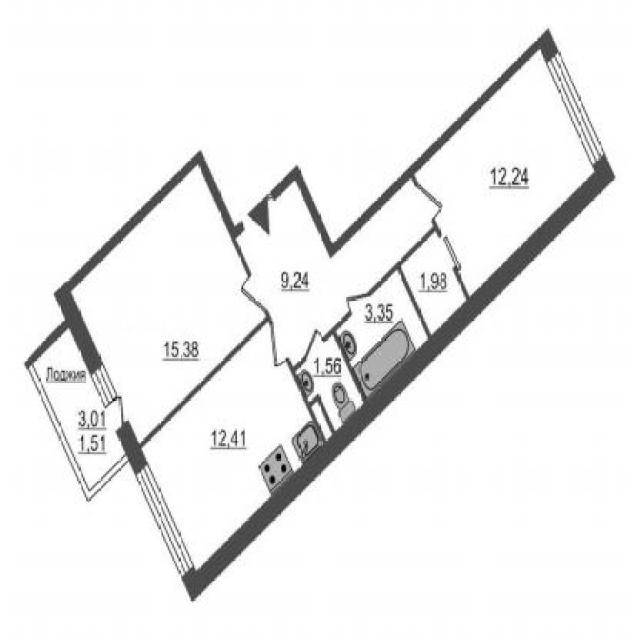

In [ ]:
# пример "косого" плана
images_dir = os.getcwd() + '/dataset2/train/images'
image_path = os.path.join(images_dir, 'a603389ba7c73c9eeadab4d06243_jpeg.rf.427bffe6811a112e78642fbb3002dac3.jpg')
image = cv2.imread(image_path)
image

3. При разметке в качестве помещения я отмечал жилые комныты и кухни. Лоджии, коридоры, туалиты и ванные размечены не были. При разметке следует определится, координаты каких помещений нам нужны.
4. Конечно использование датасета с однотипными планами приведет к хорошему результату. Вопрос: какие планы планирует исопльзовать заказчик?
5. Присутствие в датасете разноцелевых помещений (например: хол-комната, коридор-кухня, планировка комнат вообще без разделительных стен, зонирование итд)
6. Присутствие на плане квартиры помещений, которые не относятся к квартире(помещение порадной или технические карманы).
7. Присутствие на плане комнат с широким проходом без дверей.
8. Строго определить правила разметки с учетом типа помещений и толщины стен
9. Присутствие в датасете вместо плана квартиры фото 3d квартиры с видом сверху

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
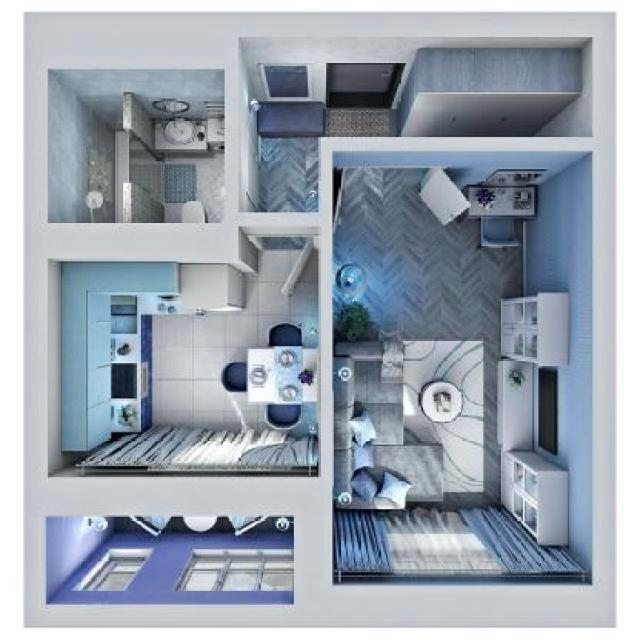

In [ ]:
# пример фото 3d квартиры с видом сверху
images_dir = os.getcwd() + '/dataset2/train/images'
image_path = os.path.join(images_dir, '04f4f03995e30e03d35c533ae975_jpeg.rf.9ca18d03a37e4e04564d1e005643005f.jpg')
image = cv2.imread(image_path)
image

10. Большая часть помещений в датасете имеет не прямоугольную форму, а многоугольную. Детекция в нашей модели ищет прямоугольники.

Изучив статьи на тему поиска координат на плане квартир. Мне очень понравилась работа HEAT: Holistic Edge Attention Transformer for Structured Reconstruction. Ссылка: https://github.com/woodfrog/heat.

В этом проекте в результате получаем граф плана этажа.
3 этапа:
* сегментация комнат (отлично справляется с многоуголными помещениями)
* поиск углов помещений через "кротчайший путь"
* слияние соседних линий чтобы получить конечный граф

Освоить и доработать этот проект под нашу задачу у меня не получилось - не хватило времени (очень много времени потратил на освоение новых знаний в рамках этого проекта). Считаю использование методов этого проекта на сложных и разноплановых планах квартир будет максимально эффективно.

# Gradio

## Визуализация работы модели

In [12]:
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (192, 192, 192), (128, 128, 128), (128, 0, 0), (128, 128, 0),
    (0, 128, 0), (128, 0, 128), (0, 128, 128), (0, 0, 128), (72, 61, 139),
    (47, 79, 79), (47, 79, 47), (0, 206, 209), (148, 0, 211), (255, 20, 147)
]

In [16]:
model = YOLO('best.pt')

In [27]:
# Функция для обработки изображения
def process_image(image_path):
    # Загрузка изображения
    image = cv2.imread(image_path)
    results = model(image)[0]

    # Получение оригинального изображения и результатов
    image = results.orig_img
    classes_names = results.names
    classes = results.boxes.cls.cpu().numpy()
    boxes = results.boxes.xyxy.cpu().numpy().astype(np.int32)

    # Подготовка словаря для группировки результатов по классам
    grouped_objects = {}

    # Рисование рамок и группировка результатов
    for class_id, box in zip(classes, boxes):
        class_name = classes_names[int(class_id)]
        color = colors[int(class_id) % len(colors)]  # Выбор цвета для класса
        if class_name not in grouped_objects:
            grouped_objects[class_name] = []
        grouped_objects[class_name].append(box)

        # Рисование рамок на изображении
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Сохранение измененного изображения
    new_image_path = os.path.splitext(image_path)[0] + '_yolo' + os.path.splitext(image_path)[1]
    cv2.imwrite(new_image_path, image)

    # Сохранение данных в текстовый файл
    text_file_path = os.path.splitext(image_path)[0] + '_data.txt'
    with open(text_file_path, 'w') as f:
        for class_name, details in grouped_objects.items():
            f.write(f"{class_name}:\n")
            for detail in details:
                f.write(f"Coordinates: ({detail[0]}, {detail[1]}, {detail[2]}, {detail[3]})\n")
    return new_image_path, text_file_path

In [47]:
image_path = os.getcwd() + '/test.jpg'
new_image_path, text_file_path = process_image(image_path)


0: 640x640 4 rooms, 189.7ms
Speed: 5.2ms preprocess, 189.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
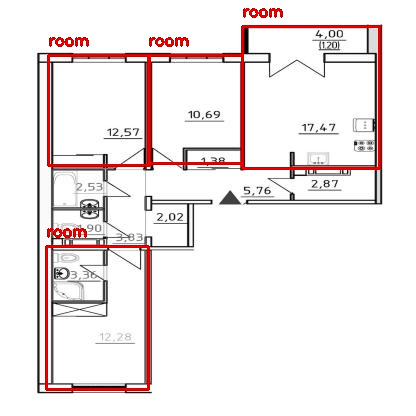

In [48]:
image = cv2.imread(new_image_path)
image

## Создание интерфейса Gradio для визуализации

In [49]:
def predict_image(img, conf_threshold, iou_threshold):
    results = model.predict(
        source=img,
        conf=conf_threshold,
        iou=iou_threshold,
        show_labels=True,
        show_conf=True,
    )
    return results[0].plot() if results else None

In [52]:
iface = gr.Interface(
    fn=predict_image,
    inputs=[
        gr.Image(type="pil", label="Upload Image"),
        gr.Slider(minimum=0, maximum=1, value=0.25, label="Confidence threshold"),
        gr.Slider(minimum=0, maximum=1, value=0.45, label="IoU threshold"),
    ],
    outputs=gr.Image(type="pil", label="Result"),
    title="Опорные координаты помещений",
    description="Загрузка плана квартиры",
)

In [53]:
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://99766b41db836cc9ca.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
